In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import os
from supervised.automl import AutoML
import category_encoders as ce
import math

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder
from sklearn.metrics import median_absolute_error
print('Imported sci-kit learn and AutoML libraries!')

Imported sci-kit learn and AutoML libraries!


# Dublin Prediction

In [2]:
# new file containing rows with our focused area of Dublin found through exploratory analysis
irl = pd.read_csv('initial-ml-test-dub-1.csv', index_col='Unnamed: 0')

In [3]:
irl.head()

,Address,County,Price (€),VAT Exclusive,UsedProperty,Property Size Description,Year,Month,Town,Apartment,...,DistanceIFSC,DistanceSchool,DistancePark,DistanceLuas,DistanceSecSchool,DistanceGPO,DistanceHospital,DistanceBeach,DistanceCar,DistanceShops
207901,"55 College Square, Terenure",Dublin,447200.00,0,0,1,2014,1,Terenure,0,...,7.541595,0.492120,1.438826,2.020029,0.156609,6.587209,2.344404,18.071721,5.427900,3.568079
207905,"Number 7 Belfort House, Sydenham Villas, Dundrum",Dublin,398000.00,1,1,0,2014,1,Dundrum Dublin,0,...,6.817210,0.100996,2.784711,0.274841,0.831639,7.118560,3.635958,14.874822,5.905557,0.255856
207916,"Apartment 16 Cedar Grove, Firhouse Road, Templ...",Dublin,196035.24,0,0,1,2014,1,Templeogue,1,...,7.799393,0.683556,3.098765,3.760897,0.968202,7.197697,3.879724,17.923987,6.179356,3.002563
207925,"75 Palmerstown Avenue, Palmerstown",Dublin,95000.00,1,1,1,2014,1,Palmerstown,0,...,8.400802,0.319564,1.909348,3.576775,0.262801,7.051363,3.811554,18.189754,6.208934,1.206681
207929,"17 Churchview Apts, Church Rd, Drumcondra",Dublin,152000.00,1,1,2,2014,1,Drumcondra,1,...,2.225835,0.085034,0.909828,1.942439,0.597393,1.805008,0.902578,10.897507,1.587952,1.815296


In [4]:
#irl['Apartment'] = irl['Apartment'].fillna(0.0)

In [5]:
# this function finds all values that fall within internationally accepted +-10% of actual prices in our predictions
# we can modify the threshold as we feel the need to here
def accuracy_threshold(test, pred, num):
    test = np.array(test)
    pred = np.array(pred)
# get within x% of actual price , not within log price as this will be misleading / incorrect
    test = np.exp(test)
    pred = np.exp(pred)
    count = 0
    for i in range(len(pred)):
        if test[i] != 0:  
            ten = test[i] * num
            res = test[i] - pred[i]
        else:
            res = 0
            ten = 0
        
        if res < 0:
            res = res * -1
        else:
            res = res
            
        if res <= ten:
            count += 1
        else:
            continue
    return (count / len(test))

In [6]:
irl.drop(columns=['VAT Exclusive'], inplace=True)
irl.head()

,Address,County,Price (€),UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,...,DistanceIFSC,DistanceSchool,DistancePark,DistanceLuas,DistanceSecSchool,DistanceGPO,DistanceHospital,DistanceBeach,DistanceCar,DistanceShops
207901,"55 College Square, Terenure",Dublin,447200.00,0,1,2014,1,Terenure,0,College Square Terenure,...,7.541595,0.492120,1.438826,2.020029,0.156609,6.587209,2.344404,18.071721,5.427900,3.568079
207905,"Number 7 Belfort House, Sydenham Villas, Dundrum",Dublin,398000.00,1,0,2014,1,Dundrum Dublin,0,Sydenham Villas Dundrum Dublin,...,6.817210,0.100996,2.784711,0.274841,0.831639,7.118560,3.635958,14.874822,5.905557,0.255856
207916,"Apartment 16 Cedar Grove, Firhouse Road, Templ...",Dublin,196035.24,0,1,2014,1,Templeogue,1,Firhouse Road Templeogue,...,7.799393,0.683556,3.098765,3.760897,0.968202,7.197697,3.879724,17.923987,6.179356,3.002563
207925,"75 Palmerstown Avenue, Palmerstown",Dublin,95000.00,1,1,2014,1,Palmerstown,0,Palmerstown Avenue Palmerstown,...,8.400802,0.319564,1.909348,3.576775,0.262801,7.051363,3.811554,18.189754,6.208934,1.206681
207929,"17 Churchview Apts, Church Rd, Drumcondra",Dublin,152000.00,1,2,2014,1,Drumcondra,1,Church Road Drumcondra,...,2.225835,0.085034,0.909828,1.942439,0.597393,1.805008,0.902578,10.897507,1.587952,1.815296


In [7]:
encoder = TargetEncoder()
irl['Town'] = encoder.fit_transform(irl['Town'], irl['PriceInflation'])

In [8]:
#encoder = TargetEncoder()
#irl['Region'] = encoder.fit_transform(irl['Region'], irl['Price (€)'])

In [9]:
encoder = TargetEncoder()
irl['County'] = encoder.fit_transform(irl['County'], irl['Price (€)'])

In [10]:
irl.head(1)

,Address,County,Price (€),UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,...,DistanceIFSC,DistanceSchool,DistancePark,DistanceLuas,DistanceSecSchool,DistanceGPO,DistanceHospital,DistanceBeach,DistanceCar,DistanceShops
207901,"55 College Square, Terenure",335411.154636,447200.0,0,1,2014,1,601864.418417,0,College Square Terenure,...,7.541595,0.49212,1.438826,2.020029,0.156609,6.587209,2.344404,18.071721,5.4279,3.568079


In [11]:
encoder = TargetEncoder()
irl['Neighbourhood'] = encoder.fit_transform(irl['Neighbourhood'], irl['PriceInflation'])

In [12]:
irl['Neighbourhood'] = irl['Neighbourhood'].round()

In [13]:
encoder = TargetEncoder()
irl['Eircode'] = encoder.fit_transform(irl['Eircode'], irl['PriceInflation'])

In [14]:
irl.head()

,Address,County,Price (€),UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,...,DistanceIFSC,DistanceSchool,DistancePark,DistanceLuas,DistanceSecSchool,DistanceGPO,DistanceHospital,DistanceBeach,DistanceCar,DistanceShops
207901,"55 College Square, Terenure",335411.154636,447200.00,0,1,2014,1,601864.418417,0,899721.0,...,7.541595,0.492120,1.438826,2.020029,0.156609,6.587209,2.344404,18.071721,5.427900,3.568079
207905,"Number 7 Belfort House, Sydenham Villas, Dundrum",335411.154636,398000.00,1,0,2014,1,651335.338306,0,1661424.0,...,6.817210,0.100996,2.784711,0.274841,0.831639,7.118560,3.635958,14.874822,5.905557,0.255856
207916,"Apartment 16 Cedar Grove, Firhouse Road, Templ...",335411.154636,196035.24,0,1,2014,1,741771.837018,1,597863.0,...,7.799393,0.683556,3.098765,3.760897,0.968202,7.197697,3.879724,17.923987,6.179356,3.002563
207925,"75 Palmerstown Avenue, Palmerstown",335411.154636,95000.00,1,1,2014,1,414681.974545,0,334587.0,...,8.400802,0.319564,1.909348,3.576775,0.262801,7.051363,3.811554,18.189754,6.208934,1.206681
207929,"17 Churchview Apts, Church Rd, Drumcondra",335411.154636,152000.00,1,2,2014,1,570683.081926,1,305308.0,...,2.225835,0.085034,0.909828,1.942439,0.597393,1.805008,0.902578,10.897507,1.587952,1.815296


In [15]:
irl['LogPrice (€)'] = np.log(irl['PriceInflation'])

In [16]:
irl = irl[['UsedProperty', 'Property Size Description', 'Year', 'Month', 'Town', 'Apartment', 'Neighbourhood',
'Eircode', 'Latitude', 'Longitude', 'DistanceIFSC', 'DistanceSchool', 'DistancePark', 'DistanceSecSchool', 'LogPrice (€)']]

In [17]:
irl.shape

(5386, 15)

In [18]:
irl.head(1)

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
207901,0,1,2014,1,601864.418417,0,899721.0,628715.337138,53.307878,-6.335665,7.541595,0.49212,1.438826,0.156609,13.648757


In [19]:
#irl.to_csv('sub-dub-encoded.csv')

In [20]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'team' column 
encoder_df = pd.DataFrame(encoder.fit_transform(irl[['Property Size Description']]).toarray())
#merge one-hot encoded columns back with original DataFrame
irl1 = irl.join(encoder_df)

In [21]:
irl

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
207901,0,1,2014,1,6.018644e+05,0,899721.0,628715.337138,53.307878,-6.335665,7.541595,0.492120,1.438826,0.156609,13.648757
207905,1,0,2014,1,6.513353e+05,0,1661424.0,651335.338306,53.288227,-6.238896,6.817210,0.100996,2.784711,0.831639,13.532203
207916,0,1,2014,1,7.417718e+05,1,597863.0,628715.337138,53.291600,-6.312400,7.799393,0.683556,3.098765,0.968202,12.824045
207925,1,1,2014,1,4.146820e+05,0,334587.0,406163.221538,53.353853,-6.372213,8.400802,0.319564,1.909348,0.262801,12.099628
207929,1,2,2014,1,5.706831e+05,1,305308.0,411979.725512,53.366311,-6.263792,2.225835,0.085034,0.909828,0.597393,12.569631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261963,1,2,2021,10,4.404562e+05,0,534236.0,440456.154028,53.491883,-6.135906,17.439163,0.099830,9.753778,1.238197,12.936154
261968,0,2,2021,11,5.859559e+05,0,599073.0,794885.173096,53.255027,-6.147053,12.378025,0.892319,1.511927,1.557293,13.169684
262028,1,2,2021,12,2.596375e+05,0,246144.0,259637.487366,53.318052,-6.372816,9.121749,1.230371,2.045147,1.054941,12.542545
262032,1,2,2021,10,1.137529e+06,0,1235166.0,794885.173096,53.282730,-6.119818,11.182747,0.468291,2.346736,0.672380,14.022525


In [22]:
x = irl.loc[:, irl.columns != 'LogPrice (€)']
y = irl['LogPrice (€)']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(X_train, y_train)

AutoML directory: AutoML_1
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.479324 trained in 1.67 seconds
2_DecisionTree rmse 0.278483 trained in 26.64 seconds
3_Linear rmse 0.296433 trained in 6.28 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.240036 trained in 5.61 seconds
5_Default_NeuralNetwork rmse 0.262624 trained in 0.98 seconds
6_Default_RandomForest rmse 0.259119 trained in 5.92 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.240036 trained in 0.36 seconds
AutoML fit time: 64.34 seconds
AutoML best model: 4_Default_Xgboost


AutoML(explain_level=2, total_time_limit=300)

In [24]:
# calculated values
y_predicted = automl.predict(X_test)
  
# Calculation of Mean Squared Error (MSE)
mean_squared_error(y_test, y_predicted)

0.06653571023329409

In [25]:
accuracy_threshold(y_test, y_predicted, 0.1)

0.5445544554455446

In [26]:
median_se = np.square(np.subtract(y_test, y_predicted)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.08880107702664441


### Let's try predict a specific years values given some historical data
We will look at using 3 years worth of data and use it to predict some data for a selected year, let's say 2021, now.

In [27]:
specific21 = irl[irl['Year'] > 2017]

A regular train to test split will not suffice here as we need only the years 2018, 2019 and 2020 in our training data, while only using the houses associated with 2021 in our test data.

In [28]:
specific21[specific21['Year'] == 2021].head()

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
218206,0,2,2021,4,353337.560204,0,347170.0,353337.560204,53.287576,-6.433316,14.222797,0.465772,6.634032,2.349923,12.716376
218208,0,2,2021,4,353337.560204,0,347170.0,353337.560204,53.286440,-6.434182,14.334534,0.327067,6.770860,2.355995,12.838977
218210,0,2,2021,4,386055.391429,0,358320.0,333925.603283,53.397993,-6.127101,9.553714,0.383226,1.822449,0.258992,13.164398
218212,0,2,2021,4,350601.406947,0,379563.0,333925.603283,53.404602,-6.154503,8.626190,0.776872,0.417361,0.603363,12.888984
218221,0,2,2021,4,353337.560204,0,347170.0,353337.560204,53.286440,-6.434182,14.334534,0.327067,6.770860,2.355995,12.744948


In [29]:
specific21.shape[0]

2817

In [30]:
train_21 = specific21[specific21['Year'] < 2021]

In [31]:
#train_21 = train_21.sample(n = 80000)
train_21.head()

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
212799,0,1,2019,1,332398.386637,0,322868.0,332398.386637,53.341446,-6.466279,14.658324,0.728724,5.931732,1.457938,12.793421
212801,0,1,2019,1,332398.386637,0,322868.0,332398.386637,53.341855,-6.465382,14.596166,0.735245,5.876450,1.383995,12.862413
212807,0,1,2019,1,329388.587019,0,308019.0,329388.587019,53.377230,-6.328681,6.307048,1.215076,0.323427,1.359171,12.835385
212810,0,1,2019,1,350601.406947,0,379563.0,333925.603283,53.404602,-6.154503,8.626190,0.776872,0.417361,0.603363,12.926953
212814,0,1,2019,1,332398.386637,0,322868.0,332398.386637,53.341448,-6.466043,14.642740,0.719977,5.916202,1.444132,12.639270


In [32]:
test_21 = specific21[specific21['Year'] == 2021]

In [33]:
x_train_21 = train_21.loc[:, train_21.columns != 'LogPrice (€)']
y_train_21 = train_21['LogPrice (€)']

In [34]:
#x_train_21.drop(columns=['Year'], inplace = True)

In [35]:
#test_21 = test_21.sample(n = 15000)
test_21.head()

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool,LogPrice (€)
218206,0,2,2021,4,353337.560204,0,347170.0,353337.560204,53.287576,-6.433316,14.222797,0.465772,6.634032,2.349923,12.716376
218208,0,2,2021,4,353337.560204,0,347170.0,353337.560204,53.286440,-6.434182,14.334534,0.327067,6.770860,2.355995,12.838977
218210,0,2,2021,4,386055.391429,0,358320.0,333925.603283,53.397993,-6.127101,9.553714,0.383226,1.822449,0.258992,13.164398
218212,0,2,2021,4,350601.406947,0,379563.0,333925.603283,53.404602,-6.154503,8.626190,0.776872,0.417361,0.603363,12.888984
218221,0,2,2021,4,353337.560204,0,347170.0,353337.560204,53.286440,-6.434182,14.334534,0.327067,6.770860,2.355995,12.744948


In [36]:
x_test_21 = test_21.loc[:, test_21.columns != 'LogPrice (€)']
y_test_21 = test_21['LogPrice (€)']

In [37]:
## explain_level gives information on feature importance when given value 1 or 2
automl1 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl1.fit(x_train_21, y_train_21)

AutoML directory: AutoML_2
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.437877 trained in 1.18 seconds
2_DecisionTree rmse 0.261823 trained in 5.24 seconds
3_Linear rmse 0.259787 trained in 3.77 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.228031 trained in 6.18 seconds
5_Default_NeuralNetwork rmse 0.244813 trained in 0.96 seconds
6_Default_RandomForest rmse 0.242553 trained in 5.15 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.22624 trained in 0.54 seconds
AutoML fit time: 36.72 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [38]:
# calculated values
y_predicted_21 = automl1.predict(x_test_21)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_predicted_21)
print('MSE for AutoML 2021 is: ' + str(mse))

MSE for AutoML 2021 is: 0.08626417800600801


In [39]:
rmse = mean_squared_error(y_test_21, y_predicted_21, squared=False)
print('RMSE for AutoML 2021 is: ' + str(rmse))

RMSE for AutoML 2021 is: 0.29370764036028757


In [40]:
acc = accuracy_threshold(y_test_21, y_predicted_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.5025380710659898


In [41]:
acc1 = accuracy_threshold(y_test_21, y_predicted_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.7360406091370558


In [42]:
median_se = np.square(np.subtract(y_test_21, y_predicted_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.09714048594281977


In [43]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test_21, y_predicted_21)
print("MAPE for AutoML 2021 is: " + str(mape))

MAPE for AutoML 2021 is: 0.013739288164974127


In [44]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df11 = pd.DataFrame(columns=cnames)

df11 = df11.append({'Algorithm': 'AutoML',
            'Year': 2021,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index=True)

In [45]:
#cnames = ['Actual', 'Predicted']
#dfreal1 = pd.DataFrame(columns = cnames)
dfreal1 = pd.DataFrame(y_test_21.values)
dfpred1 = pd.DataFrame(y_predicted_21)

### 2020 predictions

In [46]:
specific20 = irl[irl['Year'] > 2016]

In [47]:
test_20 = specific20[specific20['Year'] == 2020]
train_20 = specific20[specific20['Year'] < 2020]

In [48]:
#train_20 = train_20.sample(n = 75000)

In [49]:
x_train_20 = train_20.loc[:, train_20.columns != 'LogPrice (€)']
y_train_20 = train_20['LogPrice (€)']

In [50]:
x_test_20 = test_20.loc[:, test_20.columns != 'LogPrice (€)']
y_test_20 = test_20['LogPrice (€)']

In [51]:
automl2 = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl2.fit(x_train_20, y_train_20)

AutoML directory: AutoML_3
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.426168 trained in 1.21 seconds
2_DecisionTree rmse 0.263379 trained in 5.87 seconds
3_Linear rmse 0.277869 trained in 4.42 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.238112 trained in 6.58 seconds
5_Default_NeuralNetwork rmse 0.261129 trained in 1.72 seconds
6_Default_RandomForest rmse 0.245379 trained in 6.32 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.235522 trained in 0.48 seconds
AutoML fit time: 43.39 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [52]:
# calculated values
y_predicted_20 = automl2.predict(x_test_20)
  
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_predicted_20)
print('MSE for AutoML 2020 is: ' + str(mse))

MSE for AutoML 2020 is: 0.060522770674848174


In [53]:
rmse = mean_squared_error(y_test_20, y_predicted_20, squared=False)
print('RMSE for AutoML 2020 is: ' + str(rmse))

RMSE for AutoML 2020 is: 0.24601376114934745


In [54]:
acc = accuracy_threshold(y_test_20, y_predicted_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.5247208931419458


In [55]:
acc1 = accuracy_threshold(y_test_20, y_predicted_20, 0.2)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.7527910685805422


In [56]:
print("Median Absolute Error:\n")
print(median_absolute_error(y_test_20, y_predicted_20))

Median Absolute Error:

0.09851812271126548


In [57]:
mape = mean_absolute_percentage_error(y_test_20, y_predicted_20)
print("MAPE for AutoML 2020 is: " + str(mape))

MAPE for AutoML 2020 is: 0.012412643006640632


In [58]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df10 = pd.DataFrame(columns=cnames)

df10 = df10.append({'Algorithm': 'AutoML',
            'Year': 2020,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape
          }, ignore_index=True)

In [59]:
x_test_20

,UsedProperty,Property Size Description,Year,Month,Town,Apartment,Neighbourhood,Eircode,Latitude,Longitude,DistanceIFSC,DistanceSchool,DistancePark,DistanceSecSchool
0,1,1,2020,1,3.860554e+05,0,358320.0,333925.603283,53.401554,-6.142369,8.987333,0.872126,0.966110,0.973263
1,1,1,2020,1,4.608544e+05,1,465642.0,460854.419494,53.278220,-6.215623,8.165170,0.671500,4.581569,0.367361
2,0,1,2020,1,3.533376e+05,0,373223.0,353337.560204,53.287170,-6.433778,14.271496,0.411923,6.688568,2.360507
3,1,1,2020,1,2.626769e+05,0,249292.0,411979.725512,53.400412,-6.257995,5.729754,0.356385,0.348535,0.468681
4,0,1,2020,1,4.404562e+05,0,430431.0,440456.154028,53.481426,-6.152438,15.933497,0.984305,8.469886,2.690280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,1,2,2020,11,3.323984e+05,0,368056.0,332398.386637,53.337031,-6.456940,14.079730,0.180497,5.290860,1.356490
623,0,2,2020,12,5.859559e+05,0,599073.0,794885.173096,53.255027,-6.147053,12.378025,0.892319,1.511927,1.557293
624,1,2,2020,12,1.137529e+06,0,1774756.0,794885.173096,53.284876,-6.117710,11.132583,0.472011,2.611803,0.622215
625,1,2,2020,11,5.201112e+05,0,545398.0,794885.173096,53.245058,-6.135482,13.726257,0.664591,2.711751,0.477108


In [60]:
#cnames = ['Actual', 'Predicted']
#dfreal2 = pd.DataFrame(columns = cnames)
dfreal2 = pd.DataFrame(y_test_20.values)
dfpred2 = pd.DataFrame(y_predicted_20)
#dfreal2 = pd.concat([z1, z2], ignore_index=True)

### Multiple Linear Regression

Next, I will try implement some algorithms not specified in our autoML library which so far has only utilised XgBoost, Random Forest, Decison Tree and ensemble algorithms. I will attempt to implement other ML algorithms such as multiple linear regression and adaboost among others.

There is a couple of different libraries we can use here for linear regression:
- Sci-kit learn's linear model library
- Statsmodel

For the purpose of this I will remain consistent with the use of the sci-kit learn libraries.

In [61]:
from sklearn import linear_model

#### Let's try predict our 2021 values again using MLR

In [62]:
lm = linear_model.LinearRegression()
lm.fit(x_train_21, y_train_21) # fitting the model

LinearRegression()

In [63]:
y_pred_21 = lm.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for MLR 2021 is: ' + str(mse))

MSE for MLR 2021 is: 0.09346452989943344


In [64]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.48223350253807107


In [65]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.7055837563451777


In [66]:
median_se = np.square(np.subtract(y_test_21,y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.10950094232724616


In [67]:
mean = np.square(np.subtract(y_test_21,y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3057196917102879


In [68]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.0146696335165099


In [69]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df9 = pd.DataFrame(columns=cnames)

df9 = df9.append({'Algorithm': 'MLR',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2020 predictions

In [70]:
lm = linear_model.LinearRegression()
lm.fit(x_train_20, y_train_20) # fitting the model

LinearRegression()

In [71]:
y_pred_20 = lm.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print('MSE for MLR 2020 is: ' + str(mse))

MSE for MLR 2020 is: 0.06997893278717102


In [72]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.41467304625199364


In [73]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.15)
print('Accuracy of properties at +- 15% of actual prices is ' + str(acc1))

Accuracy of properties at +- 15% of actual prices is 0.5406698564593302


In [74]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13017858778948366


In [75]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.2645353148204809


In [76]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for MLR 2020 is: " + str(mape))

MAPE for MLR 2020 is: 0.014156547938313167


In [77]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df8 = pd.DataFrame(columns=cnames)

df8 = df8.append({'Algorithm': 'MLR',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Adaboost

#### 2021 Predictions

In [78]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

In [79]:
model = AdaBoostRegressor()

In [80]:
model.fit(x_train_21, y_train_21)

AdaBoostRegressor()

In [81]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for AdaBoost 2021 is: ' + str(mse))

MSE for AdaBoost 2021 is: 0.11992968486430097


In [82]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3299492385786802


In [83]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6192893401015228


In [84]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1601457362230665


In [85]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.3463086554856822


In [86]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for AdaBoost 2021 is: " + str(mape))

MAPE for AdaBoost 2021 is: 0.018000178785708386


In [87]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df7 = pd.DataFrame(columns=cnames)

df7 = df7.append({'Algorithm': 'AdaBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020 Predictions

In [88]:
model = AdaBoostRegressor()
model.fit(x_train_20, y_train_20)

AdaBoostRegressor()

In [89]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print('MSE for AdaBoost 2020 is: ' + str(mse))

MSE for AdaBoost 2020 is: 0.09754671939306724


In [90]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.38118022328548645


In [91]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.6443381180223285


In [92]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1568616237735032


In [93]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.312324701861808


In [94]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for AdaBoost 2020 is: " + str(mape))

MAPE for AdaBoost 2020 is: 0.016612176286059488


In [95]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df6 = pd.DataFrame(columns = cnames)

df6 = df6.append({'Algorithm': 'AdaBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

## Let's now try a selection of other algorithms on our data
### LightGBM

In [96]:
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor

### 2020 House Price Prediction Using LightGBM

In [97]:
model = LGBMRegressor()
model.fit(x_train_20, y_train_20)

LGBMRegressor()

In [98]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20,y_pred_20)
print('MSE for LightGBM 2020 is: ' + str(mse))

MSE for LightGBM 2020 is: 0.06232389310563894


In [99]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.5215311004784688


In [100]:
acc1 = accuracy_threshold(y_test_20, y_pred_20, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.7432216905901117


In [101]:
median_se = np.square(np.subtract(y_test_20,y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.09282205501731156


In [102]:
mean = np.square(np.subtract(y_test_20,y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.24964753775200535


In [103]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for LightGBM 2020 is: " + str(mape))

MAPE for LightGBM 2020 is: 0.012321946290361199


In [104]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df5 = pd.DataFrame(columns=cnames)

df5 = df5.append({'Algorithm': 'LightGBM',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### 2021

In [105]:
model = LGBMRegressor()
model.fit(x_train_21, y_train_21)

LGBMRegressor()

In [106]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21,y_pred_21)
print('MSE for LightGBM 2021 is: ' + str(mse))

MSE for LightGBM 2021 is: 0.08902990154702332


In [107]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.4619289340101523


In [108]:
acc1 = accuracy_threshold(y_test_21, y_pred_21, 0.20)
print('Accuracy of properties at +- 20% of actual prices is ' + str(acc1))

Accuracy of properties at +- 20% of actual prices is 0.7072758037225042


In [109]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.10687004472619854


In [110]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.298378788701582


In [111]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.014385014687362847


In [112]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df4 = pd.DataFrame(columns=cnames)

df4 = df4.append({'Algorithm': 'LightGBM',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### CatBoost

#### 2021 Prediction

In [113]:
from catboost import CatBoostRegressor

In [114]:
model = CatBoostRegressor()
model.fit(x_train_21, y_train_21)

Learning rate set to 0.046461
0:	learn: 0.4095685	total: 151ms	remaining: 2m 31s
1:	learn: 0.3993430	total: 155ms	remaining: 1m 17s
2:	learn: 0.3893061	total: 158ms	remaining: 52.4s
3:	learn: 0.3800505	total: 161ms	remaining: 40.1s
4:	learn: 0.3712177	total: 165ms	remaining: 32.7s
5:	learn: 0.3626008	total: 170ms	remaining: 28.1s
6:	learn: 0.3542642	total: 173ms	remaining: 24.6s
7:	learn: 0.3466779	total: 177ms	remaining: 22s
8:	learn: 0.3395992	total: 182ms	remaining: 20s
9:	learn: 0.3327191	total: 185ms	remaining: 18.3s
10:	learn: 0.3267007	total: 188ms	remaining: 16.9s
11:	learn: 0.3204400	total: 191ms	remaining: 15.7s
12:	learn: 0.3141892	total: 195ms	remaining: 14.8s
13:	learn: 0.3086293	total: 198ms	remaining: 14s
14:	learn: 0.3037503	total: 201ms	remaining: 13.2s
15:	learn: 0.2989441	total: 204ms	remaining: 12.6s
16:	learn: 0.2940816	total: 207ms	remaining: 12s
17:	learn: 0.2894964	total: 211ms	remaining: 11.5s
18:	learn: 0.2857198	total: 214ms	remaining: 11s
19:	learn: 0.282230

195:	learn: 0.1894628	total: 833ms	remaining: 3.42s
196:	learn: 0.1893393	total: 836ms	remaining: 3.4s
197:	learn: 0.1891862	total: 839ms	remaining: 3.4s
198:	learn: 0.1889938	total: 846ms	remaining: 3.4s
199:	learn: 0.1889287	total: 850ms	remaining: 3.4s
200:	learn: 0.1887899	total: 853ms	remaining: 3.39s
201:	learn: 0.1886530	total: 864ms	remaining: 3.42s
202:	learn: 0.1885102	total: 882ms	remaining: 3.46s
203:	learn: 0.1883676	total: 907ms	remaining: 3.54s
204:	learn: 0.1881568	total: 933ms	remaining: 3.62s
205:	learn: 0.1880227	total: 945ms	remaining: 3.64s
206:	learn: 0.1878731	total: 973ms	remaining: 3.73s
207:	learn: 0.1877411	total: 991ms	remaining: 3.77s
208:	learn: 0.1876515	total: 1.01s	remaining: 3.82s
209:	learn: 0.1875138	total: 1.03s	remaining: 3.86s
210:	learn: 0.1873847	total: 1.04s	remaining: 3.87s
211:	learn: 0.1872586	total: 1.05s	remaining: 3.9s
212:	learn: 0.1871428	total: 1.06s	remaining: 3.93s
213:	learn: 0.1870296	total: 1.07s	remaining: 3.93s
214:	learn: 0.186

358:	learn: 0.1674854	total: 2.45s	remaining: 4.38s
359:	learn: 0.1674336	total: 2.46s	remaining: 4.37s
360:	learn: 0.1673898	total: 2.46s	remaining: 4.36s
361:	learn: 0.1672332	total: 2.47s	remaining: 4.35s
362:	learn: 0.1671641	total: 2.47s	remaining: 4.34s
363:	learn: 0.1671197	total: 2.48s	remaining: 4.33s
364:	learn: 0.1668541	total: 2.48s	remaining: 4.32s
365:	learn: 0.1667796	total: 2.49s	remaining: 4.31s
366:	learn: 0.1667374	total: 2.49s	remaining: 4.3s
367:	learn: 0.1666934	total: 2.5s	remaining: 4.29s
368:	learn: 0.1666280	total: 2.5s	remaining: 4.28s
369:	learn: 0.1665774	total: 2.51s	remaining: 4.28s
370:	learn: 0.1665406	total: 2.52s	remaining: 4.26s
371:	learn: 0.1664759	total: 2.52s	remaining: 4.25s
372:	learn: 0.1664183	total: 2.52s	remaining: 4.25s
373:	learn: 0.1663069	total: 2.53s	remaining: 4.23s
374:	learn: 0.1662453	total: 2.53s	remaining: 4.22s
375:	learn: 0.1662078	total: 2.54s	remaining: 4.21s
376:	learn: 0.1661721	total: 2.54s	remaining: 4.2s
377:	learn: 0.16

534:	learn: 0.1500302	total: 3.14s	remaining: 2.73s
535:	learn: 0.1500058	total: 3.14s	remaining: 2.72s
536:	learn: 0.1498587	total: 3.14s	remaining: 2.71s
537:	learn: 0.1497430	total: 3.15s	remaining: 2.7s
538:	learn: 0.1496587	total: 3.15s	remaining: 2.69s
539:	learn: 0.1496329	total: 3.15s	remaining: 2.69s
540:	learn: 0.1495469	total: 3.15s	remaining: 2.68s
541:	learn: 0.1494191	total: 3.16s	remaining: 2.67s
542:	learn: 0.1491873	total: 3.16s	remaining: 2.66s
543:	learn: 0.1490407	total: 3.16s	remaining: 2.65s
544:	learn: 0.1490199	total: 3.17s	remaining: 2.64s
545:	learn: 0.1489343	total: 3.17s	remaining: 2.64s
546:	learn: 0.1488867	total: 3.17s	remaining: 2.63s
547:	learn: 0.1487951	total: 3.18s	remaining: 2.62s
548:	learn: 0.1486021	total: 3.18s	remaining: 2.61s
549:	learn: 0.1484531	total: 3.18s	remaining: 2.6s
550:	learn: 0.1483439	total: 3.19s	remaining: 2.6s
551:	learn: 0.1482369	total: 3.19s	remaining: 2.59s
552:	learn: 0.1481008	total: 3.19s	remaining: 2.58s
553:	learn: 0.1

704:	learn: 0.1345995	total: 3.71s	remaining: 1.55s
705:	learn: 0.1345670	total: 3.71s	remaining: 1.55s
706:	learn: 0.1344480	total: 3.72s	remaining: 1.54s
707:	learn: 0.1343312	total: 3.72s	remaining: 1.53s
708:	learn: 0.1342557	total: 3.72s	remaining: 1.53s
709:	learn: 0.1341379	total: 3.73s	remaining: 1.52s
710:	learn: 0.1340793	total: 3.73s	remaining: 1.52s
711:	learn: 0.1339996	total: 3.74s	remaining: 1.51s
712:	learn: 0.1339081	total: 3.74s	remaining: 1.5s
713:	learn: 0.1337960	total: 3.74s	remaining: 1.5s
714:	learn: 0.1337154	total: 3.75s	remaining: 1.49s
715:	learn: 0.1336866	total: 3.75s	remaining: 1.49s
716:	learn: 0.1336281	total: 3.75s	remaining: 1.48s
717:	learn: 0.1335175	total: 3.76s	remaining: 1.48s
718:	learn: 0.1334792	total: 3.76s	remaining: 1.47s
719:	learn: 0.1334053	total: 3.76s	remaining: 1.46s
720:	learn: 0.1333534	total: 3.77s	remaining: 1.46s
721:	learn: 0.1332504	total: 3.77s	remaining: 1.45s
722:	learn: 0.1331969	total: 3.77s	remaining: 1.44s
723:	learn: 0.

864:	learn: 0.1250232	total: 4.22s	remaining: 659ms
865:	learn: 0.1249770	total: 4.22s	remaining: 654ms
866:	learn: 0.1249346	total: 4.23s	remaining: 648ms
867:	learn: 0.1249283	total: 4.23s	remaining: 643ms
868:	learn: 0.1248270	total: 4.23s	remaining: 638ms
869:	learn: 0.1247640	total: 4.24s	remaining: 633ms
870:	learn: 0.1247462	total: 4.24s	remaining: 628ms
871:	learn: 0.1246873	total: 4.24s	remaining: 623ms
872:	learn: 0.1246650	total: 4.25s	remaining: 618ms
873:	learn: 0.1246087	total: 4.25s	remaining: 613ms
874:	learn: 0.1245691	total: 4.25s	remaining: 607ms
875:	learn: 0.1245459	total: 4.25s	remaining: 602ms
876:	learn: 0.1245257	total: 4.26s	remaining: 597ms
877:	learn: 0.1245018	total: 4.26s	remaining: 592ms
878:	learn: 0.1244313	total: 4.26s	remaining: 587ms
879:	learn: 0.1243934	total: 4.27s	remaining: 582ms
880:	learn: 0.1243294	total: 4.27s	remaining: 577ms
881:	learn: 0.1242914	total: 4.27s	remaining: 572ms
882:	learn: 0.1242733	total: 4.28s	remaining: 567ms
883:	learn: 

In [115]:
y_pred_21 = model.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print('MSE for CatBoost 2021 is: ' + str(mse))

MSE for CatBoost 2021 is: 0.09868824530192051


In [116]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.4686971235194585


In [117]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.11267776346960723


In [118]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.31414685308294993


In [119]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for CatBoost 2021 is: " + str(mape))

MAPE for CatBoost 2021 is: 0.014821081055924036


In [120]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df3 = pd.DataFrame(columns=cnames)

df3 = df3.append({'Algorithm': 'CatBoost',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [121]:
model = CatBoostRegressor()
model.fit(x_train_20, y_train_20)

Learning rate set to 0.045927
0:	learn: 0.4285466	total: 3.4ms	remaining: 3.39s
1:	learn: 0.4177271	total: 6.36ms	remaining: 3.17s
2:	learn: 0.4071235	total: 9.25ms	remaining: 3.08s
3:	learn: 0.3976982	total: 12.1ms	remaining: 3.02s
4:	learn: 0.3884625	total: 16.5ms	remaining: 3.28s
5:	learn: 0.3798459	total: 19.9ms	remaining: 3.29s
6:	learn: 0.3710699	total: 24ms	remaining: 3.4s
7:	learn: 0.3629409	total: 27.6ms	remaining: 3.42s
8:	learn: 0.3561767	total: 30.6ms	remaining: 3.37s
9:	learn: 0.3492725	total: 33.9ms	remaining: 3.35s
10:	learn: 0.3431512	total: 38.1ms	remaining: 3.43s
11:	learn: 0.3367506	total: 44.2ms	remaining: 3.64s
12:	learn: 0.3306846	total: 49.1ms	remaining: 3.73s
13:	learn: 0.3251535	total: 52.6ms	remaining: 3.7s
14:	learn: 0.3201636	total: 57.3ms	remaining: 3.76s
15:	learn: 0.3149724	total: 60.8ms	remaining: 3.74s
16:	learn: 0.3099988	total: 65.2ms	remaining: 3.77s
17:	learn: 0.3058243	total: 68.2ms	remaining: 3.72s
18:	learn: 0.3017545	total: 72.6ms	remaining: 3.7

166:	learn: 0.2040555	total: 558ms	remaining: 2.78s
167:	learn: 0.2039869	total: 561ms	remaining: 2.78s
168:	learn: 0.2038384	total: 565ms	remaining: 2.78s
169:	learn: 0.2037002	total: 568ms	remaining: 2.77s
170:	learn: 0.2034669	total: 572ms	remaining: 2.77s
171:	learn: 0.2033002	total: 575ms	remaining: 2.77s
172:	learn: 0.2031741	total: 578ms	remaining: 2.76s
173:	learn: 0.2029531	total: 581ms	remaining: 2.76s
174:	learn: 0.2028770	total: 585ms	remaining: 2.76s
175:	learn: 0.2026776	total: 588ms	remaining: 2.75s
176:	learn: 0.2023750	total: 591ms	remaining: 2.75s
177:	learn: 0.2022047	total: 594ms	remaining: 2.74s
178:	learn: 0.2020018	total: 597ms	remaining: 2.74s
179:	learn: 0.2018427	total: 600ms	remaining: 2.73s
180:	learn: 0.2015253	total: 603ms	remaining: 2.73s
181:	learn: 0.2014668	total: 606ms	remaining: 2.72s
182:	learn: 0.2012800	total: 609ms	remaining: 2.72s
183:	learn: 0.2011044	total: 613ms	remaining: 2.72s
184:	learn: 0.2009545	total: 616ms	remaining: 2.71s
185:	learn: 

329:	learn: 0.1779194	total: 1.13s	remaining: 2.29s
330:	learn: 0.1778579	total: 1.13s	remaining: 2.29s
331:	learn: 0.1778118	total: 1.14s	remaining: 2.28s
332:	learn: 0.1776603	total: 1.14s	remaining: 2.28s
333:	learn: 0.1774888	total: 1.14s	remaining: 2.27s
334:	learn: 0.1773853	total: 1.14s	remaining: 2.27s
335:	learn: 0.1772869	total: 1.15s	remaining: 2.27s
336:	learn: 0.1770201	total: 1.15s	remaining: 2.26s
337:	learn: 0.1769705	total: 1.15s	remaining: 2.26s
338:	learn: 0.1767739	total: 1.16s	remaining: 2.25s
339:	learn: 0.1765360	total: 1.16s	remaining: 2.25s
340:	learn: 0.1764292	total: 1.16s	remaining: 2.25s
341:	learn: 0.1764025	total: 1.17s	remaining: 2.24s
342:	learn: 0.1761858	total: 1.17s	remaining: 2.24s
343:	learn: 0.1761382	total: 1.17s	remaining: 2.23s
344:	learn: 0.1761228	total: 1.17s	remaining: 2.23s
345:	learn: 0.1759366	total: 1.18s	remaining: 2.22s
346:	learn: 0.1757763	total: 1.18s	remaining: 2.22s
347:	learn: 0.1756931	total: 1.18s	remaining: 2.21s
348:	learn: 

491:	learn: 0.1584817	total: 1.64s	remaining: 1.69s
492:	learn: 0.1584003	total: 1.64s	remaining: 1.69s
493:	learn: 0.1583302	total: 1.65s	remaining: 1.69s
494:	learn: 0.1581733	total: 1.65s	remaining: 1.68s
495:	learn: 0.1581128	total: 1.65s	remaining: 1.68s
496:	learn: 0.1579782	total: 1.66s	remaining: 1.68s
497:	learn: 0.1579201	total: 1.66s	remaining: 1.67s
498:	learn: 0.1577933	total: 1.66s	remaining: 1.67s
499:	learn: 0.1577750	total: 1.67s	remaining: 1.67s
500:	learn: 0.1576386	total: 1.67s	remaining: 1.66s
501:	learn: 0.1575145	total: 1.67s	remaining: 1.66s
502:	learn: 0.1574761	total: 1.67s	remaining: 1.65s
503:	learn: 0.1573011	total: 1.68s	remaining: 1.65s
504:	learn: 0.1572768	total: 1.68s	remaining: 1.65s
505:	learn: 0.1571549	total: 1.68s	remaining: 1.64s
506:	learn: 0.1570583	total: 1.69s	remaining: 1.64s
507:	learn: 0.1569549	total: 1.69s	remaining: 1.64s
508:	learn: 0.1568743	total: 1.69s	remaining: 1.63s
509:	learn: 0.1568471	total: 1.7s	remaining: 1.63s
510:	learn: 0

653:	learn: 0.1455694	total: 2.45s	remaining: 1.29s
654:	learn: 0.1455031	total: 2.45s	remaining: 1.29s
655:	learn: 0.1454816	total: 2.45s	remaining: 1.29s
656:	learn: 0.1454183	total: 2.46s	remaining: 1.28s
657:	learn: 0.1453289	total: 2.46s	remaining: 1.28s
658:	learn: 0.1452138	total: 2.46s	remaining: 1.27s
659:	learn: 0.1450758	total: 2.46s	remaining: 1.27s
660:	learn: 0.1450512	total: 2.47s	remaining: 1.27s
661:	learn: 0.1450057	total: 2.47s	remaining: 1.26s
662:	learn: 0.1448839	total: 2.47s	remaining: 1.26s
663:	learn: 0.1448499	total: 2.48s	remaining: 1.25s
664:	learn: 0.1448024	total: 2.48s	remaining: 1.25s
665:	learn: 0.1447686	total: 2.48s	remaining: 1.25s
666:	learn: 0.1447149	total: 2.49s	remaining: 1.24s
667:	learn: 0.1446330	total: 2.49s	remaining: 1.24s
668:	learn: 0.1444405	total: 2.49s	remaining: 1.23s
669:	learn: 0.1443276	total: 2.5s	remaining: 1.23s
670:	learn: 0.1442212	total: 2.5s	remaining: 1.23s
671:	learn: 0.1441600	total: 2.5s	remaining: 1.22s
672:	learn: 0.1

813:	learn: 0.1337013	total: 2.96s	remaining: 677ms
814:	learn: 0.1336557	total: 2.97s	remaining: 673ms
815:	learn: 0.1336233	total: 2.97s	remaining: 670ms
816:	learn: 0.1335759	total: 2.97s	remaining: 666ms
817:	learn: 0.1334932	total: 2.98s	remaining: 662ms
818:	learn: 0.1334266	total: 2.98s	remaining: 658ms
819:	learn: 0.1333953	total: 2.98s	remaining: 655ms
820:	learn: 0.1333563	total: 2.98s	remaining: 651ms
821:	learn: 0.1332462	total: 2.99s	remaining: 647ms
822:	learn: 0.1331495	total: 2.99s	remaining: 643ms
823:	learn: 0.1331469	total: 2.99s	remaining: 639ms
824:	learn: 0.1330687	total: 3s	remaining: 636ms
825:	learn: 0.1330187	total: 3s	remaining: 632ms
826:	learn: 0.1329493	total: 3s	remaining: 628ms
827:	learn: 0.1329241	total: 3s	remaining: 624ms
828:	learn: 0.1329120	total: 3.01s	remaining: 621ms
829:	learn: 0.1327764	total: 3.01s	remaining: 617ms
830:	learn: 0.1327202	total: 3.01s	remaining: 613ms
831:	learn: 0.1326868	total: 3.02s	remaining: 609ms
832:	learn: 0.1326467	to

972:	learn: 0.1248429	total: 3.46s	remaining: 96.1ms
973:	learn: 0.1247732	total: 3.47s	remaining: 92.6ms
974:	learn: 0.1247009	total: 3.47s	remaining: 89ms
975:	learn: 0.1246565	total: 3.47s	remaining: 85.4ms
976:	learn: 0.1245815	total: 3.48s	remaining: 81.9ms
977:	learn: 0.1245505	total: 3.48s	remaining: 78.3ms
978:	learn: 0.1245185	total: 3.48s	remaining: 74.7ms
979:	learn: 0.1244358	total: 3.49s	remaining: 71.2ms
980:	learn: 0.1243348	total: 3.49s	remaining: 67.6ms
981:	learn: 0.1242109	total: 3.49s	remaining: 64ms
982:	learn: 0.1241602	total: 3.5s	remaining: 60.5ms
983:	learn: 0.1241178	total: 3.5s	remaining: 56.9ms
984:	learn: 0.1240385	total: 3.5s	remaining: 53.3ms
985:	learn: 0.1239775	total: 3.5s	remaining: 49.8ms
986:	learn: 0.1239414	total: 3.51s	remaining: 46.2ms
987:	learn: 0.1238705	total: 3.51s	remaining: 42.6ms
988:	learn: 0.1238389	total: 3.51s	remaining: 39.1ms
989:	learn: 0.1238030	total: 3.52s	remaining: 35.5ms
990:	learn: 0.1237579	total: 3.52s	remaining: 32ms
991

In [122]:
y_pred_20 = model.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.06987298682579153


In [123]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.5263157894736842


In [124]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.08780317477186372


In [125]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.26433498978718545


In [126]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for CatBoost 2020 is: " + str(mape))

MAPE for CatBoost 2020 is: 0.012957074906781186


In [127]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df2 = pd.DataFrame(columns=cnames)

df2 = df2.append({'Algorithm': 'CatBoost',
            'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

### Bayesian Ridge

#### 2021

In [128]:
from sklearn.linear_model import BayesianRidge, LinearRegression

In [129]:
clf = BayesianRidge()
clf.fit(x_train_21, y_train_21)

BayesianRidge()

In [130]:
y_pred_21 = clf.predict(x_test_21)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_21, y_pred_21)
print(mse)

0.09331216467214079


In [131]:
acc = accuracy_threshold(y_test_21, y_pred_21, 0.1)
print(acc)

0.47377326565143824


In [132]:
median_se = np.square(np.subtract(y_test_21, y_pred_21)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.10550579904085922


In [133]:
mean = np.square(np.subtract(y_test_21, y_pred_21)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.30547039901132944


In [134]:
mape = mean_absolute_percentage_error(y_test_21, y_pred_21)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.014756565752005934


In [135]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df1 = pd.DataFrame(columns=cnames)

df1 = df1.append({'Algorithm': 'Bayesian',
            'Year': 2021,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape       
          }, ignore_index=True)

#### 2020

In [136]:
clf = BayesianRidge()
clf.fit(x_train_20, y_train_20)

BayesianRidge()

In [137]:
y_pred_20 = clf.predict(x_test_20)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_20, y_pred_20)
print(mse)

0.06996643217540555


In [138]:
acc = accuracy_threshold(y_test_20, y_pred_20, 0.1)
print(acc)

0.4258373205741627


In [139]:
median_se = np.square(np.subtract(y_test_20, y_pred_20)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13307828582210668


In [140]:
mean = np.square(np.subtract(y_test_20, y_pred_20)).mean() 
 
mean = math.sqrt(mean)
print("Root Mean Square Error:\n")
print(mean)

Root Mean Square Error:

0.2645116862737929


In [141]:
mape = mean_absolute_percentage_error(y_test_20, y_pred_20)
print("MAPE for BayesianRidge 2021 is: " + str(mape))

MAPE for BayesianRidge 2021 is: 0.014118274876478034


In [142]:
cnames=['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df = pd.DataFrame(columns=cnames)

df = df.append({'Algorithm': 'Bayesian',
           'Year': 2020,
           'RMSE': mean,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape     
          }, ignore_index=True)

In [143]:
vis = pd.concat([df, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11], ignore_index=True)

## Let's test on more years of data now
### 2019

In [144]:
specific19 = irl[irl['Year'] > 2015]

In [145]:
test_19 = specific19[specific19['Year'] == 2019]
train_19 = specific19[specific19['Year'] < 2019]

#train_19 = train_19.sample(n = 80000)
#test_19 = test_19.sample(n = 20000)

In [146]:
x_train_19 = train_19.loc[:, train_19.columns != 'LogPrice (€)']
y_train_19 = train_19['LogPrice (€)']
x_test_19 = test_19.loc[:, test_19.columns != 'LogPrice (€)']
y_test_19 = test_19['LogPrice (€)']

In [147]:
#x_train_19.drop(columns=['Year'], inplace = True)
#x_test_19.drop(columns=['Year'], inplace = True)

#### AutoML

In [148]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_19, y_train_19)

AutoML directory: AutoML_4
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.48067 trained in 1.2 seconds
2_DecisionTree rmse 0.275411 trained in 5.26 seconds
3_Linear rmse 0.27897 trained in 4.14 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.251506 trained in 5.84 seconds
5_Default_NeuralNetwork rmse 0.279234 trained in 1.94 seconds
6_Default_RandomForest rmse 0.252988 trained in 9.9 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.245583 trained in 1.28 seconds
AutoML fit time: 44.38 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [149]:
y_pred_19 = automl.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AutoML 2019 is: ' + str(mse))

MSE for AutoML 2019 is: 0.046949677958873004


In [150]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.5414572864321608


In [151]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared=False)
print('RMSE for AutoML 2019 is: ' + str(rmse))

RMSE for AutoML 2019 is: 0.2166787436710694


In [152]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.09240440774768745


In [153]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AutoML 2019 is: " + str(mape))

MAPE for AutoML 2019 is: 0.011244264264091617


In [154]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df12 = pd.DataFrame(columns = cnames)

df12 = df12.append({'Algorithm': 'AutoML',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [155]:
#cnames = ['Actual', 'Predicted']
#dfreal3 = pd.DataFrame(columns = cnames)
dfreal3 = pd.DataFrame(y_test_19.values)
dfpred3 = pd.DataFrame(y_pred_19)
#dfreal3 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [156]:
lm = linear_model.LinearRegression()
lm.fit(x_train_19, y_train_19) # fitting the model
y_pred_19 = lm.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for MLR 2019 is: ' + str(mse))

MSE for MLR 2019 is: 0.0556341324314192


In [157]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.2358688882227141


In [158]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1378710353082416


In [159]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.4020100502512563


In [160]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for MLR 2021 is: " + str(mape))

MAPE for MLR 2021 is: 0.013546080575402224


In [161]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df13 = pd.DataFrame(columns = cnames)

df13 = df13.append({'Algorithm': 'MLR',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [162]:
model = AdaBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for AdaBoost 2019 is: ' + str(mse))

MSE for AdaBoost 2019 is: 0.06838124693380575


In [163]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for MLR 2019 is: ' + str(rmse))

RMSE for MLR 2019 is: 0.26149808208437353


In [164]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.11233698491614241


In [165]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.4635678391959799


In [166]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for AdaBoost 2019 is: " + str(mape))

MAPE for AdaBoost 2019 is: 0.01331816092270101


In [167]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df14 = pd.DataFrame(columns = cnames)

df14 = df14.append({'Algorithm': 'AdaBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [168]:
model = LGBMRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for LightGBM 2019 is: ' + str(mse))

MSE for LightGBM 2019 is: 0.05419931380191135


In [169]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.23280746079520592


In [170]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.10452539503942655


In [171]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.4849246231155779


In [172]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for LightGBM 2019 is: " + str(mape))

MAPE for LightGBM 2019 is: 0.012273702469383231


In [173]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df15 = pd.DataFrame(columns = cnames)

df15 = df15.append({'Algorithm': 'LightGBM',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [174]:
model = CatBoostRegressor()
model.fit(x_train_19, y_train_19)
y_pred_19 = model.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for CatBoost 2019 is: ' + str(mse))

Learning rate set to 0.044561
0:	learn: 0.5004809	total: 4.02ms	remaining: 4.02s
1:	learn: 0.4886068	total: 7.38ms	remaining: 3.68s
2:	learn: 0.4761619	total: 10.2ms	remaining: 3.4s
3:	learn: 0.4649775	total: 13ms	remaining: 3.24s
4:	learn: 0.4540877	total: 15.8ms	remaining: 3.14s
5:	learn: 0.4440449	total: 19.2ms	remaining: 3.19s
6:	learn: 0.4346240	total: 23.5ms	remaining: 3.34s
7:	learn: 0.4256072	total: 26.8ms	remaining: 3.33s
8:	learn: 0.4175326	total: 30.3ms	remaining: 3.34s
9:	learn: 0.4088563	total: 33.5ms	remaining: 3.31s
10:	learn: 0.4011638	total: 37.4ms	remaining: 3.36s
11:	learn: 0.3933473	total: 40.6ms	remaining: 3.35s
12:	learn: 0.3860491	total: 44.2ms	remaining: 3.35s
13:	learn: 0.3800134	total: 47.1ms	remaining: 3.31s
14:	learn: 0.3734674	total: 51.6ms	remaining: 3.39s
15:	learn: 0.3678508	total: 54.5ms	remaining: 3.35s
16:	learn: 0.3623018	total: 58ms	remaining: 3.35s
17:	learn: 0.3572092	total: 61.1ms	remaining: 3.33s
18:	learn: 0.3522973	total: 64.6ms	remaining: 3.3

168:	learn: 0.2270201	total: 593ms	remaining: 2.92s
169:	learn: 0.2266646	total: 597ms	remaining: 2.91s
170:	learn: 0.2263129	total: 599ms	remaining: 2.9s
171:	learn: 0.2260833	total: 603ms	remaining: 2.9s
172:	learn: 0.2260211	total: 607ms	remaining: 2.9s
173:	learn: 0.2259140	total: 610ms	remaining: 2.9s
174:	learn: 0.2256149	total: 613ms	remaining: 2.89s
175:	learn: 0.2254419	total: 616ms	remaining: 2.88s
176:	learn: 0.2251060	total: 619ms	remaining: 2.88s
177:	learn: 0.2248736	total: 622ms	remaining: 2.87s
178:	learn: 0.2246807	total: 625ms	remaining: 2.87s
179:	learn: 0.2244305	total: 628ms	remaining: 2.86s
180:	learn: 0.2242412	total: 631ms	remaining: 2.85s
181:	learn: 0.2240699	total: 634ms	remaining: 2.85s
182:	learn: 0.2238708	total: 636ms	remaining: 2.84s
183:	learn: 0.2236848	total: 639ms	remaining: 2.83s
184:	learn: 0.2235369	total: 642ms	remaining: 2.83s
185:	learn: 0.2231537	total: 645ms	remaining: 2.82s
186:	learn: 0.2229081	total: 649ms	remaining: 2.82s
187:	learn: 0.22

328:	learn: 0.1999176	total: 1.1s	remaining: 2.25s
329:	learn: 0.1997971	total: 1.11s	remaining: 2.25s
330:	learn: 0.1997028	total: 1.11s	remaining: 2.25s
331:	learn: 0.1995526	total: 1.11s	remaining: 2.24s
332:	learn: 0.1994760	total: 1.12s	remaining: 2.24s
333:	learn: 0.1993005	total: 1.12s	remaining: 2.24s
334:	learn: 0.1991042	total: 1.13s	remaining: 2.23s
335:	learn: 0.1988599	total: 1.13s	remaining: 2.23s
336:	learn: 0.1986362	total: 1.13s	remaining: 2.23s
337:	learn: 0.1983748	total: 1.13s	remaining: 2.22s
338:	learn: 0.1981202	total: 1.14s	remaining: 2.22s
339:	learn: 0.1978969	total: 1.14s	remaining: 2.22s
340:	learn: 0.1976391	total: 1.14s	remaining: 2.21s
341:	learn: 0.1974415	total: 1.15s	remaining: 2.21s
342:	learn: 0.1972205	total: 1.15s	remaining: 2.2s
343:	learn: 0.1970961	total: 1.15s	remaining: 2.2s
344:	learn: 0.1968825	total: 1.16s	remaining: 2.2s
345:	learn: 0.1966518	total: 1.16s	remaining: 2.19s
346:	learn: 0.1965452	total: 1.16s	remaining: 2.19s
347:	learn: 0.19

491:	learn: 0.1762914	total: 1.62s	remaining: 1.67s
492:	learn: 0.1762488	total: 1.62s	remaining: 1.67s
493:	learn: 0.1761348	total: 1.62s	remaining: 1.66s
494:	learn: 0.1760434	total: 1.63s	remaining: 1.66s
495:	learn: 0.1758767	total: 1.63s	remaining: 1.66s
496:	learn: 0.1758314	total: 1.63s	remaining: 1.65s
497:	learn: 0.1756934	total: 1.64s	remaining: 1.65s
498:	learn: 0.1755547	total: 1.64s	remaining: 1.65s
499:	learn: 0.1753931	total: 1.64s	remaining: 1.64s
500:	learn: 0.1752315	total: 1.65s	remaining: 1.64s
501:	learn: 0.1751359	total: 1.65s	remaining: 1.63s
502:	learn: 0.1750105	total: 1.65s	remaining: 1.63s
503:	learn: 0.1748759	total: 1.65s	remaining: 1.63s
504:	learn: 0.1747287	total: 1.66s	remaining: 1.62s
505:	learn: 0.1745981	total: 1.66s	remaining: 1.62s
506:	learn: 0.1744359	total: 1.66s	remaining: 1.61s
507:	learn: 0.1742587	total: 1.66s	remaining: 1.61s
508:	learn: 0.1741496	total: 1.67s	remaining: 1.61s
509:	learn: 0.1739487	total: 1.67s	remaining: 1.6s
510:	learn: 0

662:	learn: 0.1573072	total: 2.21s	remaining: 1.13s
663:	learn: 0.1572274	total: 2.22s	remaining: 1.12s
664:	learn: 0.1571742	total: 2.22s	remaining: 1.12s
665:	learn: 0.1570674	total: 2.22s	remaining: 1.11s
666:	learn: 0.1569599	total: 2.23s	remaining: 1.11s
667:	learn: 0.1569080	total: 2.23s	remaining: 1.11s
668:	learn: 0.1568733	total: 2.23s	remaining: 1.1s
669:	learn: 0.1568091	total: 2.24s	remaining: 1.1s
670:	learn: 0.1566693	total: 2.24s	remaining: 1.1s
671:	learn: 0.1565951	total: 2.24s	remaining: 1.09s
672:	learn: 0.1564283	total: 2.25s	remaining: 1.09s
673:	learn: 0.1562875	total: 2.25s	remaining: 1.09s
674:	learn: 0.1562526	total: 2.25s	remaining: 1.08s
675:	learn: 0.1561673	total: 2.26s	remaining: 1.08s
676:	learn: 0.1560740	total: 2.26s	remaining: 1.08s
677:	learn: 0.1560155	total: 2.26s	remaining: 1.07s
678:	learn: 0.1559825	total: 2.27s	remaining: 1.07s
679:	learn: 0.1559214	total: 2.27s	remaining: 1.07s
680:	learn: 0.1558170	total: 2.27s	remaining: 1.06s
681:	learn: 0.1

828:	learn: 0.1440917	total: 2.76s	remaining: 569ms
829:	learn: 0.1440581	total: 2.76s	remaining: 566ms
830:	learn: 0.1440362	total: 2.76s	remaining: 562ms
831:	learn: 0.1439747	total: 2.77s	remaining: 559ms
832:	learn: 0.1438367	total: 2.77s	remaining: 556ms
833:	learn: 0.1437890	total: 2.77s	remaining: 552ms
834:	learn: 0.1437567	total: 2.78s	remaining: 549ms
835:	learn: 0.1436749	total: 2.78s	remaining: 545ms
836:	learn: 0.1436231	total: 2.78s	remaining: 542ms
837:	learn: 0.1435632	total: 2.79s	remaining: 539ms
838:	learn: 0.1434537	total: 2.79s	remaining: 535ms
839:	learn: 0.1433332	total: 2.79s	remaining: 532ms
840:	learn: 0.1432647	total: 2.79s	remaining: 528ms
841:	learn: 0.1431219	total: 2.8s	remaining: 525ms
842:	learn: 0.1430389	total: 2.8s	remaining: 522ms
843:	learn: 0.1429865	total: 2.8s	remaining: 518ms
844:	learn: 0.1428720	total: 2.81s	remaining: 515ms
845:	learn: 0.1427973	total: 2.81s	remaining: 511ms
846:	learn: 0.1427492	total: 2.81s	remaining: 508ms
847:	learn: 0.1

997:	learn: 0.1327486	total: 3.58s	remaining: 7.17ms
998:	learn: 0.1327014	total: 3.58s	remaining: 3.58ms
999:	learn: 0.1326637	total: 3.58s	remaining: 0us
MSE for CatBoost 2019 is: 0.05205657846442003


In [175]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.22815910778318718


In [176]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.106564926009109


In [177]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.48115577889447236


In [178]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for CatBoost 2019 is: " + str(mape))

MAPE for CatBoost 2019 is: 0.011860966281682154


In [179]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df16 = pd.DataFrame(columns = cnames)

df16 = df16.append({'Algorithm': 'CatBoost',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [180]:
clf = BayesianRidge()
clf.fit(x_train_19, y_train_19)
y_pred_19 = clf.predict(x_test_19)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_19, y_pred_19)
print('MSE for BayesianRidge 2019 is: ' + str(mse))

MSE for BayesianRidge 2019 is: 0.05523348136638259


In [181]:
rmse = mean_squared_error(y_test_19, y_pred_19, squared = False)
print('RMSE for LightGBM 2019 is: ' + str(rmse))

RMSE for LightGBM 2019 is: 0.23501804476759353


In [182]:
median_se = np.square(np.subtract(y_test_19, y_pred_19)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1340508147253413


In [183]:
acc = accuracy_threshold(y_test_19, y_pred_19, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.4108040201005025


In [184]:
mape = mean_absolute_percentage_error(y_test_19, y_pred_19)
print("MAPE for BayesianRidge 2019 is: " + str(mape))

MAPE for BayesianRidge 2019 is: 0.013347742300340849


In [185]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df17 = pd.DataFrame(columns = cnames)

df17 = df17.append({'Algorithm': 'Bayesian',
           'Year': 2019,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2018

In [186]:
specific18 = irl[irl['Year'] > 2014]
test_18 = specific18[specific18['Year'] == 2018]
train_18 = specific18[specific18['Year'] < 2018]

#train_18 = train_18.sample(n = 80000)
#test_18 = test_18.sample(n = 20000)

x_train_18 = train_18.loc[:, train_18.columns != 'LogPrice (€)']
y_train_18 = train_18['LogPrice (€)']
x_test_18 = test_18.loc[:, test_18.columns != 'LogPrice (€)']
y_test_18 = test_18['LogPrice (€)']

In [187]:
#x_test_18.drop(columns=['Year'], inplace = True)
#x_train_18.drop(columns=['Year'], inplace = True)

### AutoML

In [188]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_18, y_train_18)

AutoML directory: AutoML_5
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.585488 trained in 1.44 seconds
2_DecisionTree rmse 0.328493 trained in 6.34 seconds
3_Linear rmse 0.355903 trained in 4.88 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.288014 trained in 5.84 seconds
5_Default_NeuralNetwork rmse 0.318083 trained in 1.04 seconds
6_Default_RandomForest rmse 0.300903 trained in 5.14 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.284744 trained in 0.5 seconds
AutoML fit time: 41.43 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [189]:
y_pred_18 = automl.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AutoML 2018 is: ' + str(mse))

MSE for AutoML 2018 is: 0.08877812669548124


In [190]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.44956413449564137


In [191]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for AutoML 2018 is: ' + str(rmse))

RMSE for AutoML 2018 is: 0.2979565852527533


In [192]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.10934222404414129


In [193]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for AutoML 2018 is: " + str(mape))

MAPE for AutoML 2018 is: 0.01435853662589125


In [194]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy','MAPE']
df18 = pd.DataFrame(columns = cnames)

df18 = df18.append({'Algorithm': 'AutoML',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [195]:
#cnames = ['Actual', 'Predicted']
#dfreal4 = pd.DataFrame(columns = cnames)
dfreal4 = pd.DataFrame(y_test_18.values)
dfpred4 = pd.DataFrame(y_pred_18)
#dfreal4 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [196]:
lm = linear_model.LinearRegression()
lm.fit(x_train_18, y_train_18) # fitting the model
y_pred_18 = lm.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for MLR 2018 is: ' + str(mse))

MSE for MLR 2018 is: 0.09745262617714515


In [197]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3972602739726027


In [198]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.3121740318750827


In [199]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.12791719358337694


In [200]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.015876701358758995


In [201]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df19 = pd.DataFrame(columns = cnames)

df19 = df19.append({'Algorithm': 'MLR',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [202]:
model = AdaBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for AdaBoost 2018 is: ' + str(mse))

MSE for AdaBoost 2018 is: 0.10933035660939379


In [203]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.39103362391033625


In [204]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1393660895626141


In [205]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.33065141253198027


In [206]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for MLR 2018 is: " + str(mape))

MAPE for MLR 2018 is: 0.017354291907142896


In [207]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df20 = pd.DataFrame(columns = cnames)

df20 = df20.append({'Algorithm': 'AdaBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [208]:
model = LGBMRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for LightGBM 2018 is: ' + str(mse))

MSE for LightGBM 2018 is: 0.08968159665598194


In [209]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.45454545454545453


In [210]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.11185607856721802


In [211]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for LightGBM 2018 is: ' + str(rmse))

RMSE for LightGBM 2018 is: 0.29946885757284003


In [212]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for LightGBM 2021 is: " + str(mape))

MAPE for LightGBM 2021 is: 0.014371752140115131


In [213]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df21 = pd.DataFrame(columns = cnames)

df21 = df21.append({'Algorithm': 'LightGBM',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [214]:
model = CatBoostRegressor()
model.fit(x_train_18, y_train_18)
y_pred_18 = model.predict(x_test_18)

Learning rate set to 0.044382
0:	learn: 0.5539680	total: 3.04ms	remaining: 3.04s
1:	learn: 0.5394392	total: 6.1ms	remaining: 3.04s
2:	learn: 0.5250851	total: 9.05ms	remaining: 3.01s
3:	learn: 0.5113586	total: 13.4ms	remaining: 3.33s
4:	learn: 0.4988134	total: 16.7ms	remaining: 3.32s
5:	learn: 0.4866223	total: 20.1ms	remaining: 3.34s
6:	learn: 0.4749644	total: 23.4ms	remaining: 3.31s
7:	learn: 0.4639048	total: 27.8ms	remaining: 3.44s
8:	learn: 0.4541079	total: 31.4ms	remaining: 3.45s
9:	learn: 0.4438175	total: 34.9ms	remaining: 3.46s
10:	learn: 0.4344207	total: 37.8ms	remaining: 3.4s
11:	learn: 0.4258266	total: 42.6ms	remaining: 3.51s
12:	learn: 0.4174705	total: 46.1ms	remaining: 3.5s
13:	learn: 0.4100241	total: 49.7ms	remaining: 3.5s
14:	learn: 0.4028340	total: 53.6ms	remaining: 3.52s
15:	learn: 0.3953089	total: 57.2ms	remaining: 3.52s
16:	learn: 0.3889064	total: 60ms	remaining: 3.47s
17:	learn: 0.3821217	total: 62.8ms	remaining: 3.42s
18:	learn: 0.3761385	total: 65.8ms	remaining: 3.4s

163:	learn: 0.2413730	total: 513ms	remaining: 2.62s
164:	learn: 0.2412087	total: 516ms	remaining: 2.61s
165:	learn: 0.2410207	total: 519ms	remaining: 2.61s
166:	learn: 0.2408509	total: 522ms	remaining: 2.6s
167:	learn: 0.2406594	total: 526ms	remaining: 2.6s
168:	learn: 0.2405480	total: 529ms	remaining: 2.6s
169:	learn: 0.2402697	total: 532ms	remaining: 2.6s
170:	learn: 0.2400812	total: 535ms	remaining: 2.59s
171:	learn: 0.2398325	total: 538ms	remaining: 2.59s
172:	learn: 0.2395771	total: 542ms	remaining: 2.59s
173:	learn: 0.2392590	total: 545ms	remaining: 2.59s
174:	learn: 0.2390612	total: 548ms	remaining: 2.58s
175:	learn: 0.2389080	total: 550ms	remaining: 2.58s
176:	learn: 0.2386946	total: 554ms	remaining: 2.58s
177:	learn: 0.2384588	total: 557ms	remaining: 2.57s
178:	learn: 0.2382202	total: 560ms	remaining: 2.57s
179:	learn: 0.2380481	total: 563ms	remaining: 2.56s
180:	learn: 0.2379216	total: 565ms	remaining: 2.56s
181:	learn: 0.2377317	total: 568ms	remaining: 2.55s
182:	learn: 0.23

326:	learn: 0.2123411	total: 1.02s	remaining: 2.11s
327:	learn: 0.2122548	total: 1.03s	remaining: 2.11s
328:	learn: 0.2122228	total: 1.03s	remaining: 2.1s
329:	learn: 0.2120768	total: 1.03s	remaining: 2.1s
330:	learn: 0.2118887	total: 1.04s	remaining: 2.1s
331:	learn: 0.2117628	total: 1.04s	remaining: 2.1s
332:	learn: 0.2115989	total: 1.04s	remaining: 2.09s
333:	learn: 0.2113890	total: 1.05s	remaining: 2.09s
334:	learn: 0.2111983	total: 1.05s	remaining: 2.09s
335:	learn: 0.2110696	total: 1.05s	remaining: 2.08s
336:	learn: 0.2107378	total: 1.06s	remaining: 2.08s
337:	learn: 0.2106372	total: 1.06s	remaining: 2.08s
338:	learn: 0.2103650	total: 1.06s	remaining: 2.07s
339:	learn: 0.2102683	total: 1.07s	remaining: 2.07s
340:	learn: 0.2101534	total: 1.07s	remaining: 2.07s
341:	learn: 0.2099531	total: 1.07s	remaining: 2.06s
342:	learn: 0.2097968	total: 1.07s	remaining: 2.06s
343:	learn: 0.2096568	total: 1.08s	remaining: 2.06s
344:	learn: 0.2095019	total: 1.08s	remaining: 2.05s
345:	learn: 0.20

500:	learn: 0.1875212	total: 1.54s	remaining: 1.53s
501:	learn: 0.1874061	total: 1.54s	remaining: 1.53s
502:	learn: 0.1872808	total: 1.54s	remaining: 1.52s
503:	learn: 0.1871195	total: 1.54s	remaining: 1.52s
504:	learn: 0.1869906	total: 1.55s	remaining: 1.52s
505:	learn: 0.1868909	total: 1.55s	remaining: 1.51s
506:	learn: 0.1867132	total: 1.55s	remaining: 1.51s
507:	learn: 0.1866281	total: 1.56s	remaining: 1.51s
508:	learn: 0.1865795	total: 1.56s	remaining: 1.5s
509:	learn: 0.1864932	total: 1.56s	remaining: 1.5s
510:	learn: 0.1863339	total: 1.57s	remaining: 1.5s
511:	learn: 0.1862161	total: 1.57s	remaining: 1.5s
512:	learn: 0.1861280	total: 1.57s	remaining: 1.49s
513:	learn: 0.1860919	total: 1.57s	remaining: 1.49s
514:	learn: 0.1860452	total: 1.58s	remaining: 1.49s
515:	learn: 0.1859260	total: 1.58s	remaining: 1.48s
516:	learn: 0.1857309	total: 1.58s	remaining: 1.48s
517:	learn: 0.1855016	total: 1.59s	remaining: 1.48s
518:	learn: 0.1854409	total: 1.59s	remaining: 1.47s
519:	learn: 0.18

675:	learn: 0.1699497	total: 2.05s	remaining: 984ms
676:	learn: 0.1698581	total: 2.06s	remaining: 981ms
677:	learn: 0.1698044	total: 2.06s	remaining: 978ms
678:	learn: 0.1696933	total: 2.06s	remaining: 974ms
679:	learn: 0.1696052	total: 2.06s	remaining: 972ms
680:	learn: 0.1694256	total: 2.07s	remaining: 969ms
681:	learn: 0.1692566	total: 2.07s	remaining: 966ms
682:	learn: 0.1692007	total: 2.07s	remaining: 962ms
683:	learn: 0.1691532	total: 2.08s	remaining: 959ms
684:	learn: 0.1690945	total: 2.08s	remaining: 957ms
685:	learn: 0.1689699	total: 2.08s	remaining: 954ms
686:	learn: 0.1688778	total: 2.09s	remaining: 951ms
687:	learn: 0.1688323	total: 2.09s	remaining: 947ms
688:	learn: 0.1687431	total: 2.09s	remaining: 944ms
689:	learn: 0.1687126	total: 2.1s	remaining: 941ms
690:	learn: 0.1685968	total: 2.1s	remaining: 941ms
691:	learn: 0.1685299	total: 2.11s	remaining: 940ms
692:	learn: 0.1684219	total: 2.12s	remaining: 938ms
693:	learn: 0.1683554	total: 2.13s	remaining: 938ms
694:	learn: 0.

835:	learn: 0.1574680	total: 2.8s	remaining: 549ms
836:	learn: 0.1573728	total: 2.8s	remaining: 545ms
837:	learn: 0.1572933	total: 2.8s	remaining: 542ms
838:	learn: 0.1572689	total: 2.8s	remaining: 538ms
839:	learn: 0.1571816	total: 2.81s	remaining: 535ms
840:	learn: 0.1571134	total: 2.81s	remaining: 532ms
841:	learn: 0.1570621	total: 2.81s	remaining: 528ms
842:	learn: 0.1569297	total: 2.82s	remaining: 525ms
843:	learn: 0.1568837	total: 2.82s	remaining: 521ms
844:	learn: 0.1568380	total: 2.82s	remaining: 518ms
845:	learn: 0.1567648	total: 2.83s	remaining: 514ms
846:	learn: 0.1566283	total: 2.83s	remaining: 511ms
847:	learn: 0.1565431	total: 2.83s	remaining: 508ms
848:	learn: 0.1564910	total: 2.83s	remaining: 504ms
849:	learn: 0.1563937	total: 2.84s	remaining: 501ms
850:	learn: 0.1563018	total: 2.84s	remaining: 497ms
851:	learn: 0.1562223	total: 2.84s	remaining: 494ms
852:	learn: 0.1561346	total: 2.85s	remaining: 490ms
853:	learn: 0.1561092	total: 2.85s	remaining: 487ms
854:	learn: 0.15

997:	learn: 0.1472574	total: 3.27s	remaining: 6.55ms
998:	learn: 0.1472443	total: 3.27s	remaining: 3.27ms
999:	learn: 0.1471998	total: 3.27s	remaining: 0us


In [215]:
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for CatBoost 2018 is: ' + str(mse))

MSE for CatBoost 2018 is: 0.09984747388247861


In [216]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.45454545454545453


In [217]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.11204221860158903


In [218]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for CatBoost 2018 is: ' + str(rmse))

RMSE for CatBoost 2018 is: 0.3159865090197343


In [219]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for CatBoost 2018 is: " + str(mape))

MAPE for CatBoost 2018 is: 0.014791922671128579


In [220]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df22 = pd.DataFrame(columns = cnames)

df22 = df22.append({'Algorithm': 'CatBoost',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [221]:
clf = BayesianRidge()
clf.fit(x_train_18, y_train_18)
y_pred_18 = clf.predict(x_test_18)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_18, y_pred_18)
print('MSE for BayesianRidge 2018 is: ' + str(mse))

MSE for BayesianRidge 2018 is: 0.09740068086229178


In [222]:
acc = accuracy_threshold(y_test_18, y_pred_18, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.34620174346201743


In [223]:
mape = mean_absolute_percentage_error(y_test_18, y_pred_18)
print("MAPE for BayesianRidge 2018 is: " + str(mape))

MAPE for BayesianRidge 2018 is: 0.01603426483012557


In [224]:
median_se = np.square(np.subtract(y_test_18, y_pred_18)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13985117639529498


In [225]:
rmse = mean_squared_error(y_test_18, y_pred_18, squared = False)
print('RMSE for MLR 2018 is: ' + str(rmse))

RMSE for MLR 2018 is: 0.31209082149639034


In [226]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df23 = pd.DataFrame(columns = cnames)

df23 = df23.append({'Algorithm': 'Bayesian',
           'Year': 2018,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

## 2017

In [227]:
specific17 = irl[irl['Year'] > 2013]
test_17 = specific17[specific17['Year'] == 2017]
train_17 = specific17[specific17['Year'] < 2017]

x_train_17 = train_17.loc[:, train_17.columns != 'LogPrice (€)']
y_train_17 = train_17['LogPrice (€)']
x_test_17 = test_17.loc[:, test_17.columns != 'LogPrice (€)']
y_test_17 = test_17['LogPrice (€)']

In [228]:
automl = AutoML(total_time_limit = 5 * 60, explain_level = 2)
automl.fit(x_train_17, y_train_17)

AutoML directory: AutoML_6
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline rmse 0.572215 trained in 1.04 seconds
2_DecisionTree rmse 0.311896 trained in 6.9 seconds
3_Linear rmse 0.330217 trained in 4.85 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost rmse 0.269985 trained in 6.48 seconds
5_Default_NeuralNetwork rmse 0.296374 trained in 1.04 seconds
6_Default_RandomForest rmse 0.29362 trained in 6.19 seconds
* Step ensemble will try to check up to 1 model
Ensemble rmse 0.268827 trained in 0.33 seconds
AutoML fit time: 41.72 seconds
AutoML best model: Ensemble


AutoML(explain_level=2, total_time_limit=300)

In [229]:
y_pred_17 = automl.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AutoML 2017 is: ' + str(mse))

MSE for AutoML 2017 is: 0.08739858304228534


In [230]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for AutoML 2017 is: ' + str(rmse))

RMSE for AutoML 2017 is: 0.29563251350669356


In [231]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.44680851063829785


In [232]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.11909544809923826


In [233]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AutoML 2017 is: " + str(mape))

MAPE for AutoML 2017 is: 0.014941585595465231


In [234]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df24 = pd.DataFrame(columns = cnames)

df24 = df24.append({'Algorithm': 'AutoML',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [235]:
#cnames = ['Actual', 'Predicted']
#dfreal5 = pd.DataFrame(columns = cnames)
dfreal5 = pd.DataFrame(y_test_17.values)
dfpred5 = pd.DataFrame(y_pred_17)
#dfreal5 = pd.concat([z1, z2], ignore_index=True)

### MLR

In [236]:
lm = linear_model.LinearRegression()
lm.fit(x_train_17, y_train_17) # fitting the model
y_pred_17 = lm.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for MLR 2017 is: ' + str(mse))

MSE for MLR 2017 is: 0.11774632727001243


In [237]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for MLR 2017 is: ' + str(rmse))

RMSE for MLR 2017 is: 0.3431418471565548


In [238]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3468085106382979


In [239]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16687263111707593


In [240]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for MLR 2017 is: " + str(mape))

MAPE for MLR 2017 is: 0.018456471452181038


In [241]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df25 = pd.DataFrame(columns = cnames)

df25 = df25.append({'Algorithm': 'MLR',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### AdaBoost

In [242]:
model = AdaBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for AdaBoost 2017 is: ' + str(mse))

MSE for AdaBoost 2017 is: 0.0975752938950291


In [243]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for Adaboost 2017 is: ' + str(rmse))

RMSE for Adaboost 2017 is: 0.31237044337617653


In [244]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.34893617021276596


In [245]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.16213382731021575


In [246]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for AdaBoost 2017 is: " + str(mape))

MAPE for AdaBoost 2017 is: 0.0175017479096011


In [247]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df26 = pd.DataFrame(columns = cnames)

df26 = df26.append({'Algorithm': 'AdaBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### LightGBM

In [248]:
model = LGBMRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for LightGBM 2017 is: ' + str(mse))

MSE for LightGBM 2017 is: 0.09180809051084973


In [249]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for LightGBM 2017 is: ' + str(rmse))

RMSE for LightGBM 2017 is: 0.30299849918910443


In [250]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.42340425531914894


In [251]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.11778997492048514


In [252]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for LightGBM 2017 is: " + str(mape))

MAPE for LightGBM 2017 is: 0.015434334013122197


In [253]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df27 = pd.DataFrame(columns = cnames)

df27 = df27.append({'Algorithm': 'LightGBM',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### CatBoost

In [254]:
model = CatBoostRegressor()
model.fit(x_train_17, y_train_17)
y_pred_17 = model.predict(x_test_17)

Learning rate set to 0.046032
0:	learn: 0.5618668	total: 3.9ms	remaining: 3.89s
1:	learn: 0.5457524	total: 7.61ms	remaining: 3.8s
2:	learn: 0.5301779	total: 12.6ms	remaining: 4.2s
3:	learn: 0.5155368	total: 16.6ms	remaining: 4.13s
4:	learn: 0.5018235	total: 53.5ms	remaining: 10.6s
5:	learn: 0.4893835	total: 61.9ms	remaining: 10.3s
6:	learn: 0.4768347	total: 72.2ms	remaining: 10.2s
7:	learn: 0.4659068	total: 87.5ms	remaining: 10.8s
8:	learn: 0.4554361	total: 97.4ms	remaining: 10.7s
9:	learn: 0.4452306	total: 108ms	remaining: 10.7s
10:	learn: 0.4358832	total: 116ms	remaining: 10.4s
11:	learn: 0.4271822	total: 126ms	remaining: 10.4s
12:	learn: 0.4175739	total: 146ms	remaining: 11.1s
13:	learn: 0.4090753	total: 154ms	remaining: 10.8s
14:	learn: 0.4012950	total: 165ms	remaining: 10.8s
15:	learn: 0.3937527	total: 174ms	remaining: 10.7s
16:	learn: 0.3865417	total: 181ms	remaining: 10.5s
17:	learn: 0.3798730	total: 187ms	remaining: 10.2s
18:	learn: 0.3733477	total: 196ms	remaining: 10.1s
19:	l

167:	learn: 0.2392386	total: 1.03s	remaining: 5.13s
168:	learn: 0.2391337	total: 1.04s	remaining: 5.11s
169:	learn: 0.2389557	total: 1.04s	remaining: 5.09s
170:	learn: 0.2387227	total: 1.04s	remaining: 5.07s
171:	learn: 0.2385678	total: 1.05s	remaining: 5.04s
172:	learn: 0.2383408	total: 1.05s	remaining: 5.03s
173:	learn: 0.2381782	total: 1.05s	remaining: 5s
174:	learn: 0.2379682	total: 1.06s	remaining: 4.98s
175:	learn: 0.2377597	total: 1.06s	remaining: 4.96s
176:	learn: 0.2375995	total: 1.06s	remaining: 4.94s
177:	learn: 0.2374389	total: 1.06s	remaining: 4.92s
178:	learn: 0.2373223	total: 1.07s	remaining: 4.9s
179:	learn: 0.2372236	total: 1.07s	remaining: 4.88s
180:	learn: 0.2371025	total: 1.07s	remaining: 4.86s
181:	learn: 0.2370060	total: 1.08s	remaining: 4.85s
182:	learn: 0.2368280	total: 1.08s	remaining: 4.83s
183:	learn: 0.2366088	total: 1.08s	remaining: 4.82s
184:	learn: 0.2364066	total: 1.09s	remaining: 4.8s
185:	learn: 0.2361831	total: 1.09s	remaining: 4.78s
186:	learn: 0.236

327:	learn: 0.2139871	total: 1.79s	remaining: 3.68s
328:	learn: 0.2138519	total: 1.8s	remaining: 3.67s
329:	learn: 0.2137829	total: 1.8s	remaining: 3.66s
330:	learn: 0.2135282	total: 1.8s	remaining: 3.65s
331:	learn: 0.2134184	total: 1.81s	remaining: 3.63s
332:	learn: 0.2132579	total: 1.81s	remaining: 3.62s
333:	learn: 0.2131253	total: 1.81s	remaining: 3.61s
334:	learn: 0.2129631	total: 1.81s	remaining: 3.6s
335:	learn: 0.2128172	total: 1.82s	remaining: 3.59s
336:	learn: 0.2126081	total: 1.82s	remaining: 3.58s
337:	learn: 0.2124806	total: 1.82s	remaining: 3.57s
338:	learn: 0.2122510	total: 1.83s	remaining: 3.56s
339:	learn: 0.2121330	total: 1.83s	remaining: 3.55s
340:	learn: 0.2120607	total: 1.83s	remaining: 3.55s
341:	learn: 0.2118282	total: 1.84s	remaining: 3.54s
342:	learn: 0.2116656	total: 1.84s	remaining: 3.53s
343:	learn: 0.2116265	total: 1.84s	remaining: 3.52s
344:	learn: 0.2115155	total: 1.85s	remaining: 3.51s
345:	learn: 0.2113643	total: 1.85s	remaining: 3.5s
346:	learn: 0.211

493:	learn: 0.1949391	total: 2.31s	remaining: 2.36s
494:	learn: 0.1948508	total: 2.31s	remaining: 2.36s
495:	learn: 0.1947635	total: 2.31s	remaining: 2.35s
496:	learn: 0.1945432	total: 2.32s	remaining: 2.34s
497:	learn: 0.1943816	total: 2.32s	remaining: 2.34s
498:	learn: 0.1942753	total: 2.32s	remaining: 2.33s
499:	learn: 0.1941954	total: 2.33s	remaining: 2.33s
500:	learn: 0.1940594	total: 2.33s	remaining: 2.32s
501:	learn: 0.1939998	total: 2.33s	remaining: 2.31s
502:	learn: 0.1939300	total: 2.33s	remaining: 2.31s
503:	learn: 0.1938446	total: 2.34s	remaining: 2.3s
504:	learn: 0.1938047	total: 2.34s	remaining: 2.29s
505:	learn: 0.1937015	total: 2.34s	remaining: 2.29s
506:	learn: 0.1935842	total: 2.35s	remaining: 2.28s
507:	learn: 0.1934961	total: 2.35s	remaining: 2.28s
508:	learn: 0.1934622	total: 2.35s	remaining: 2.27s
509:	learn: 0.1933351	total: 2.36s	remaining: 2.27s
510:	learn: 0.1932797	total: 2.36s	remaining: 2.26s
511:	learn: 0.1932201	total: 2.37s	remaining: 2.26s
512:	learn: 0

665:	learn: 0.1809923	total: 2.87s	remaining: 1.44s
666:	learn: 0.1809199	total: 2.87s	remaining: 1.43s
667:	learn: 0.1808880	total: 2.87s	remaining: 1.43s
668:	learn: 0.1808515	total: 2.87s	remaining: 1.42s
669:	learn: 0.1807510	total: 2.88s	remaining: 1.42s
670:	learn: 0.1807060	total: 2.88s	remaining: 1.41s
671:	learn: 0.1805838	total: 2.88s	remaining: 1.41s
672:	learn: 0.1804725	total: 2.89s	remaining: 1.4s
673:	learn: 0.1803994	total: 2.89s	remaining: 1.4s
674:	learn: 0.1803541	total: 2.89s	remaining: 1.39s
675:	learn: 0.1803160	total: 2.9s	remaining: 1.39s
676:	learn: 0.1802477	total: 2.9s	remaining: 1.38s
677:	learn: 0.1801871	total: 2.9s	remaining: 1.38s
678:	learn: 0.1801264	total: 2.9s	remaining: 1.37s
679:	learn: 0.1800285	total: 2.91s	remaining: 1.37s
680:	learn: 0.1799913	total: 2.91s	remaining: 1.36s
681:	learn: 0.1799487	total: 2.91s	remaining: 1.36s
682:	learn: 0.1799152	total: 2.92s	remaining: 1.35s
683:	learn: 0.1797993	total: 2.92s	remaining: 1.35s
684:	learn: 0.1797

832:	learn: 0.1704388	total: 3.38s	remaining: 677ms
833:	learn: 0.1704302	total: 3.38s	remaining: 673ms
834:	learn: 0.1703436	total: 3.38s	remaining: 669ms
835:	learn: 0.1702973	total: 3.39s	remaining: 664ms
836:	learn: 0.1702303	total: 3.39s	remaining: 660ms
837:	learn: 0.1700699	total: 3.39s	remaining: 656ms
838:	learn: 0.1700205	total: 3.4s	remaining: 651ms
839:	learn: 0.1699784	total: 3.4s	remaining: 647ms
840:	learn: 0.1698925	total: 3.4s	remaining: 643ms
841:	learn: 0.1698844	total: 3.4s	remaining: 639ms
842:	learn: 0.1697842	total: 3.41s	remaining: 634ms
843:	learn: 0.1697412	total: 3.41s	remaining: 630ms
844:	learn: 0.1697264	total: 3.41s	remaining: 626ms
845:	learn: 0.1696295	total: 3.42s	remaining: 622ms
846:	learn: 0.1695227	total: 3.42s	remaining: 618ms
847:	learn: 0.1694713	total: 3.42s	remaining: 614ms
848:	learn: 0.1694293	total: 3.42s	remaining: 609ms
849:	learn: 0.1693973	total: 3.43s	remaining: 605ms
850:	learn: 0.1693465	total: 3.43s	remaining: 601ms
851:	learn: 0.16

999:	learn: 0.1609752	total: 3.89s	remaining: 0us


In [255]:
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for CatBoost 2017 is: ' + str(mse))

MSE for CatBoost 2017 is: 0.08268384033103753


In [256]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for CatBoost 2017 is: ' + str(rmse))

RMSE for CatBoost 2017 is: 0.28754797918093167


In [257]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.39148936170212767


In [258]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.13748968681539292


In [259]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for CatBoost 2017 is: " + str(mape))

MAPE for CatBoost 2017 is: 0.015069767348711221


In [260]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df28 = pd.DataFrame(columns = cnames)

df28 = df28.append({'Algorithm': 'CatBoost',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

### BayesianRidge

In [261]:
clf = BayesianRidge()
clf.fit(x_train_17, y_train_17)
y_pred_17 = clf.predict(x_test_17)
# Calculation of Mean Squared Error (MSE)
mse = mean_squared_error(y_test_17, y_pred_17)
print('MSE for BayesianRidge 2017 is: ' + str(mse))

MSE for BayesianRidge 2017 is: 0.11783934144280493


In [262]:
rmse = mean_squared_error(y_test_17, y_pred_17, squared = False)
print('RMSE for BayesianRidge 2017 is: ' + str(rmse))

RMSE for BayesianRidge 2017 is: 0.3432773535245297


In [263]:
acc = accuracy_threshold(y_test_17, y_pred_17, 0.1)
print('Accuracy of properties at +- 10% of actual prices is ' + str(acc))

Accuracy of properties at +- 10% of actual prices is 0.3468085106382979


In [264]:
median_se = np.square(np.subtract(y_test_17, y_pred_17)).median() 
 
med = math.sqrt(median_se)
print("Median Absolute Error:\n")
print(med)

Median Absolute Error:

0.1641085624638191


In [265]:
mape = mean_absolute_percentage_error(y_test_17, y_pred_17)
print("MAPE for BayesianRidge 2017 is: " + str(mape))

MAPE for BayesianRidge 2017 is: 0.018316097256833308


In [266]:
cnames = ['Algorithm', 'Year', 'RMSE', 'MSE', 'MEDAE', 'Accuracy', 'MAPE']
df29 = pd.DataFrame(columns = cnames)

df29 = df29.append({'Algorithm': 'Bayesian',
           'Year': 2017,
           'RMSE': rmse,
           'MSE': mse,
           'MEDAE': med,
           'Accuracy': acc,
           'MAPE': mape         
          }, ignore_index = True)

In [267]:
vis1 = pd.concat([df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23,
                df24, df25, df26, df27, df28, df29], ignore_index=True)

In [268]:
vis2 = pd.concat([vis, vis1], ignore_index=True)

## Let's Visualize all our results 

<AxesSubplot:title={'center':'Mean RMSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean RMSE'>

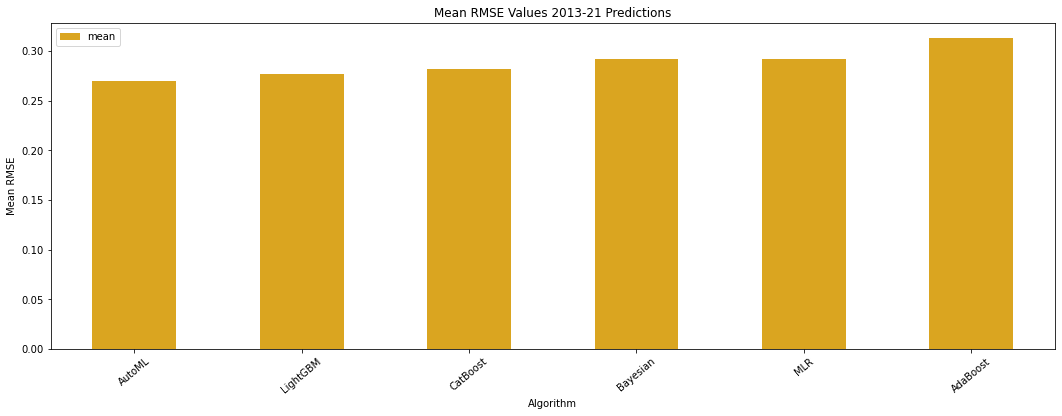

In [269]:
# rmse results
grouped_multiple1 = vis2.groupby(['Algorithm']).agg({'RMSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple1.columns = ['mean','median','max','sum']
grouped_multiple1.reset_index(inplace = True)
distdf = grouped_multiple1.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='goldenrod', xlabel='Algorithm', ylabel='Mean RMSE', title='Mean RMSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MEDAE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MEDAE'>

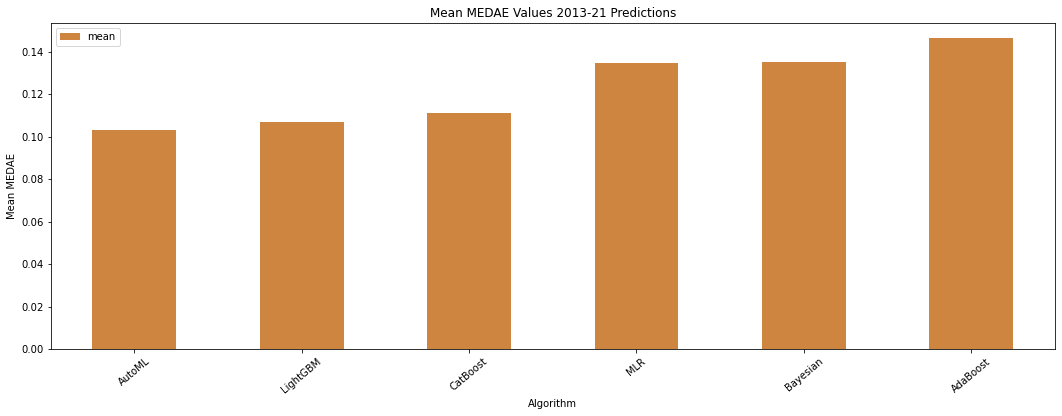

In [270]:
# median results
grouped_multiple2 = vis2.groupby(['Algorithm']).agg({'MEDAE': ['mean', 'median', 'max', 'sum']})
grouped_multiple2.columns = ['mean','median','max','sum']
grouped_multiple2.reset_index(inplace = True)
distdf = grouped_multiple2.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='peru', xlabel='Algorithm', ylabel='Mean MEDAE', title='Mean MEDAE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean Accuracy Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Average Accuracy'>

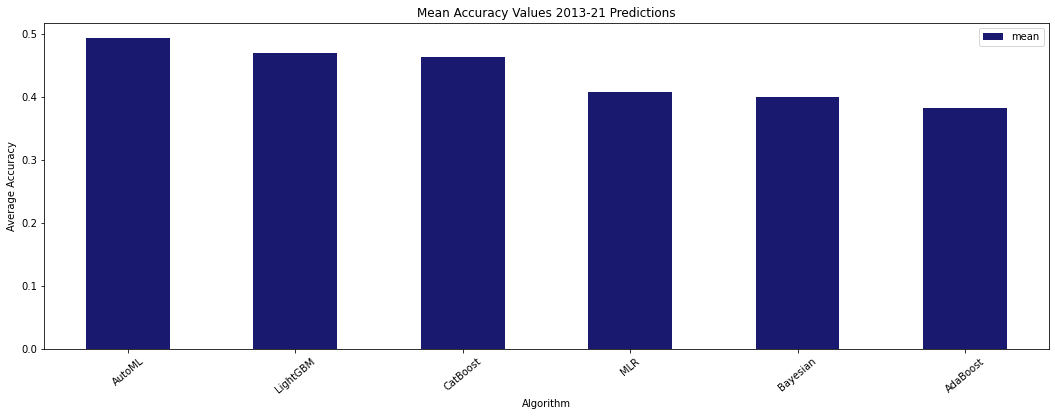

In [272]:
grouped_multiple3 = vis2.groupby(['Algorithm']).agg({'Accuracy': ['mean', 'median', 'max', 'sum', 'min']})
grouped_multiple3.columns = ['mean','median','max','sum', 'min']
grouped_multiple3.reset_index(inplace = True)
distdf = grouped_multiple3.sort_values(by = ['mean'], ascending = False)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='midnightblue', xlabel='Algorithm', ylabel='Average Accuracy', title='Mean Accuracy Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MSE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MSE'>

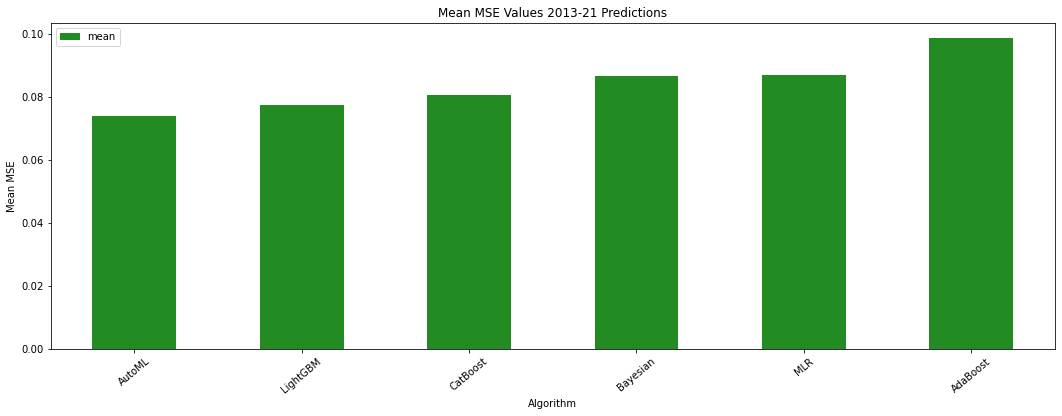

In [273]:
# mse results
grouped_multiple4 = vis2.groupby(['Algorithm']).agg({'MSE': ['mean', 'median', 'max', 'sum']})
grouped_multiple4.columns = ['mean','median','max','sum']
grouped_multiple4.reset_index(inplace = True)
distdf = grouped_multiple4.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='forestgreen', xlabel='Algorithm', ylabel='Mean MSE', title='Mean MSE Values 2013-21 Predictions')

<AxesSubplot:title={'center':'Mean MAPE Values 2013-21 Predictions'}, xlabel='Algorithm', ylabel='Mean MAPE'>

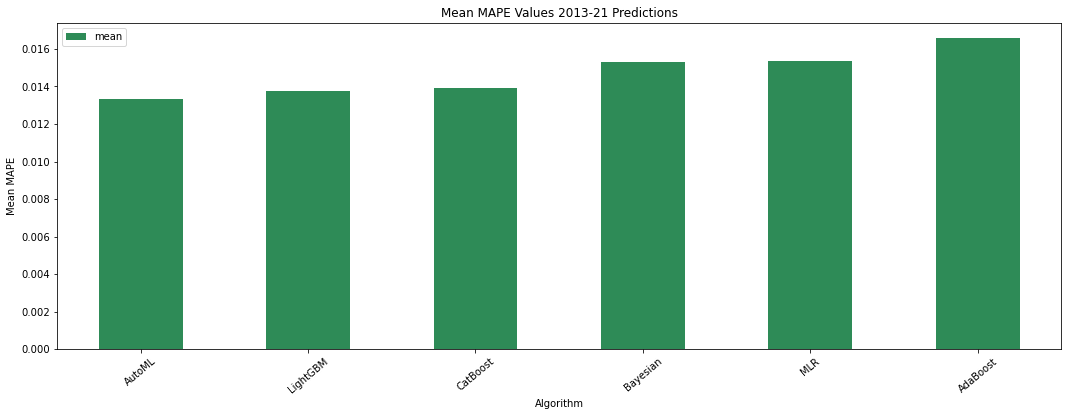

In [274]:
# mape results
grouped_multiple5 = vis2.groupby(['Algorithm']).agg({'MAPE': ['mean', 'median', 'max', 'sum']})
grouped_multiple5.columns = ['mean','median','max','sum']
grouped_multiple5.reset_index(inplace = True)
distdf = grouped_multiple5.sort_values(by = ['mean'], ascending = True)
distdf.plot.bar(x = 'Algorithm', y = 'mean', rot = 40, figsize=(18, 6), color='seagreen', xlabel='Algorithm', ylabel='Mean MAPE', title='Mean MAPE Values 2013-21 Predictions')

Result that can be compared around 6/7 % off [this](https://arxiv.org/pdf/2108.09175.pdf), (slightly diff approach taken by me predicting yearly however!)

In [275]:
grouped_multiple3.sort_values(by = 'mean', ascending = False)

,Algorithm,mean,median,max,sum,min
1,AutoML,0.493018,0.502538,0.541457,2.465089,0.446809
4,LightGBM,0.469267,0.461929,0.521531,2.346334,0.423404
3,CatBoost,0.464441,0.468697,0.526316,2.322204,0.391489
5,MLR,0.408597,0.402010,0.482234,2.042985,0.346809
2,Bayesian,0.400685,0.410804,0.473773,2.003425,0.346202
0,AdaBoost,0.382933,0.381180,0.463568,1.914667,0.329949


<AxesSubplot:title={'center':'Performance of ML algorithms accuracy from 2017-2021 Predictions'}, xlabel='Year'>

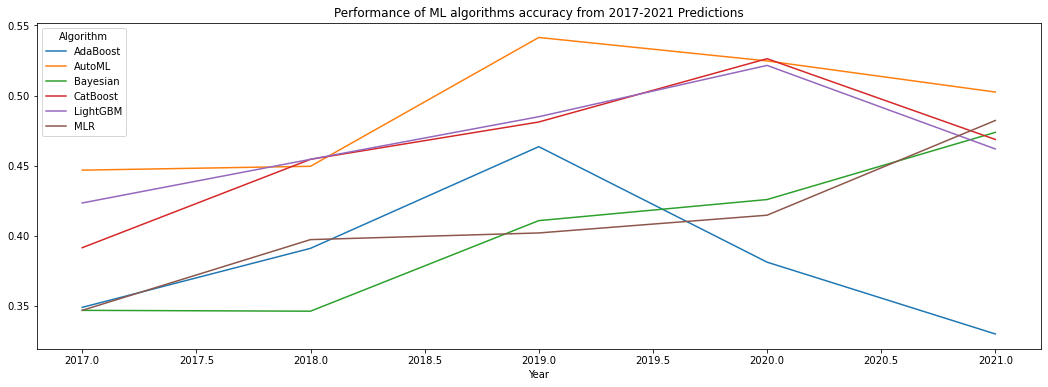

In [276]:
# yearly accuracy results
df = vis2.pivot(index = 'Year', columns = 'Algorithm', values = 'Accuracy')
df.plot(figsize = (18, 6), title = 'Performance of ML algorithms accuracy from 2017-2021 Predictions')

It is definitely worth noting the steep rise in performance of our prediction models after 2018. Looking at our AutoML approach in particular this sees a jump of 10% in predictive performance from 2018 to 2019 and remains well above 2017 and 2018 performance values. Looking across the board it definitely seems that our models are better suited to more up to date data, which is definitely a good thing. It may also suggest that the importance of our features changes noticeably over time with features such as closeness to parks and so forth maybe appearing more favourably in the midst of the global pandemic from 2020 onwards.

### Let's plot our Actual VS Predicted values for our best model - AutoML

In [277]:
actual = pd.concat([dfreal1, dfreal2, dfreal3, dfreal4, dfreal5], ignore_index=True)

In [278]:
actual.rename(columns = {0: 'Actual'}, inplace = True)
actual.head()

,Actual
0,12.716376
1,12.838977
2,13.164398
3,12.888984
4,12.744948


In [279]:
pred = pd.concat([dfpred1, dfpred2, dfpred3, dfpred4, dfpred5], ignore_index=True)

In [280]:
pred.rename(columns={0: 'Predicted'}, inplace = True)
pred.head()

,Predicted
0,12.776343
1,12.792749
2,12.615387
3,12.883091
4,12.792749


In [281]:
actualvpred = actual.join(pred)

In [282]:
actualvpred.head()

,Actual,Predicted
0,12.716376,12.776343
1,12.838977,12.792749
2,13.164398,12.615387
3,12.888984,12.883091
4,12.744948,12.792749


In [283]:
# actual prices for better plot
exp = np.exp(actualvpred)

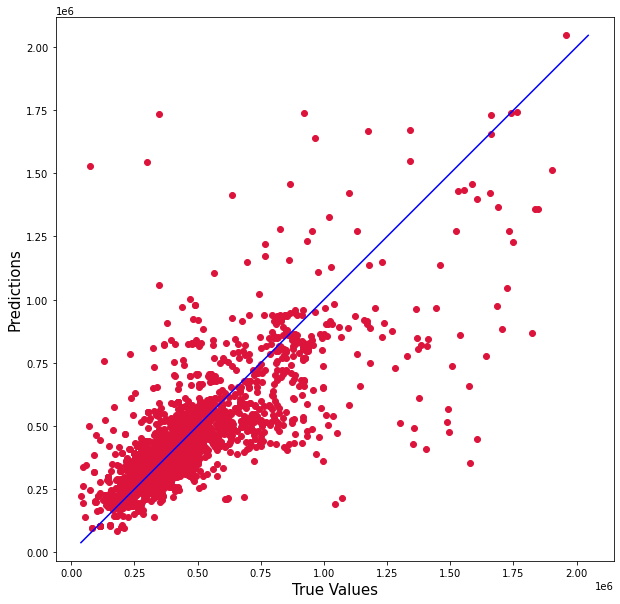

In [284]:
# plot predicted vs actual
plt.figure(figsize = (10, 10))
plt.scatter(exp['Actual'], exp['Predicted'], c = 'crimson')

p1 = max(max(exp['Predicted']), max(exp['Actual']))
p2 = min(min(exp['Predicted']), min(exp['Actual']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

### Predictions and True Values Evaluation

Our model is certainly most accurate between the 250,000€ to ~600,000€ range. There is definitely far more outliers as we increase our true values to around the 1,000,000€ mark. Some of these more expensive properties are definitely accurate (2 of note around 1.75m mark) but definitely we see it more accurate at the lower / average end of values. 

### Let's plot locations of our Properties and Accuracy of our results

In [285]:
import geopandas as gpd
ROI_map = gpd.read_file('counties\counties.shp')  #reading the shape file for our maps 
ROI_map.head(1)

2022-03-16 14:38:15,667 fiona._env ERROR Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.
2022-03-16 14:38:15,669 fiona._env ERROR Unable to open EPSG support file gcs.csv.  Try setting the GDAL_DATA environment variable to point to the directory containing EPSG csv files.


,OSM_ID,NAME_TAG,NAME_GA,NAME_EN,ALT_NAME,ALT_NAME_G,LOGAINM_RE,OSM_USER,OSM_TIMEST,ATTRIBUTIO,T_IE_URL,AREA,LATITUDE,LONGITUDE,EPOCH_TSTM,geometry
0,-338539.0,Mayo,Contae Mhaigh Eo,County Mayo,None,None,100023,Polarbear,2009-11-28 21:59:01+01,None,http://www.townlands.ie/mayo,5.596522e+09,53.924239,-9.385225,1.259442e+09,"MULTIPOLYGON (((-10.13689 54.10969, -10.13601 ..."


In [286]:
dub = ROI_map.loc[ROI_map['NAME_TAG'] == 'Dublin']
dub

,OSM_ID,NAME_TAG,NAME_GA,NAME_EN,ALT_NAME,ALT_NAME_G,LOGAINM_RE,OSM_USER,OSM_TIMEST,ATTRIBUTIO,T_IE_URL,AREA,LATITUDE,LONGITUDE,EPOCH_TSTM,geometry
23,-282800.0,Dublin,Contae Ãtha Cliath,County Dublin,None,None,100002,mackerski,2009-10-07 01:32:34+02,None,http://www.townlands.ie/dublin,9.290204e+08,53.392222,-6.283976,1.254872e+09,"MULTIPOLYGON (((-6.54689 53.27948, -6.54642 53..."


In [287]:
dub1 = dub[['NAME_TAG', 'LATITUDE', 'LONGITUDE', 'geometry']]

Text(0.5, 1.0, 'Plot of the Locations of Properties used in this dataset')

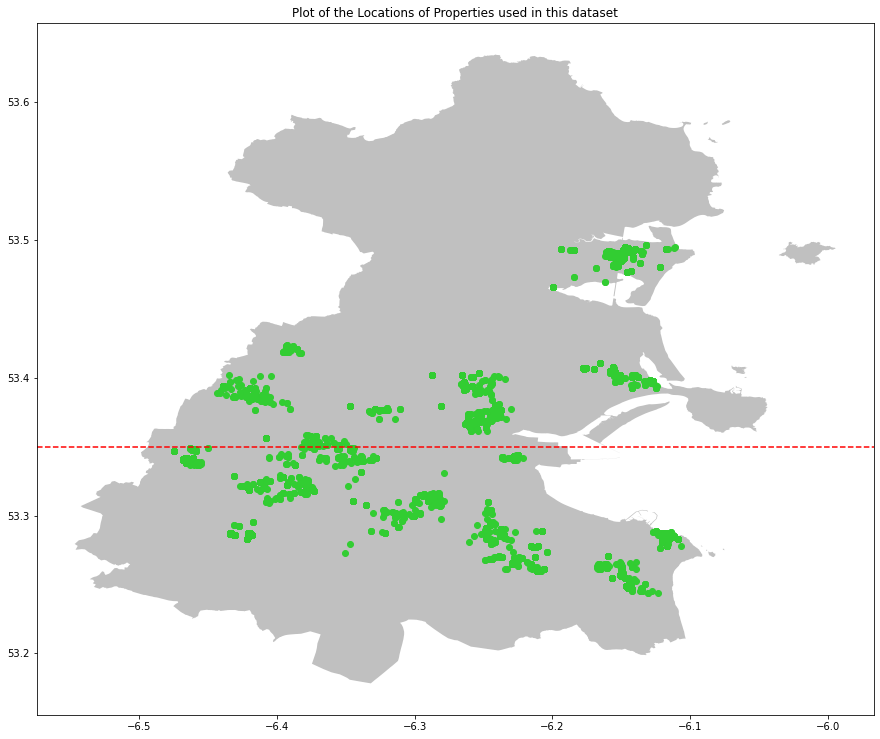

In [288]:
fig, ax = plt.subplots(figsize = (15, 15))
# O'Connell St. lat is 53.34975, and the longitude is -6.260113
dub1.plot(ax = ax, color = 'silver')
ax.axhline(y = 53.34975, color='r', linestyle = '--')
plt.scatter(x = irl['Longitude'], y = irl['Latitude'], color = 'limegreen')
plt.title('Plot of the Locations of Properties used in this dataset')

### Location of Accurate VS Inaccurate

In [289]:
l1 = dfreal1.join(x_test_21[['Longitude', 'Latitude']])
l2 = dfreal2.join(x_test_20[['Longitude', 'Latitude']])
l3 = dfreal3.join(x_test_19[['Longitude', 'Latitude']])
l4 = dfreal4.join(x_test_18[['Longitude', 'Latitude']])
l5 = dfreal5.join(x_test_17[['Longitude', 'Latitude']])

In [290]:
plots = pd.concat([l1, l2, l3, l4, l5], ignore_index=True)

In [291]:
plots.rename(columns = {0 : 'Actual'}, inplace = True)

In [292]:
plotscomp = plots.join(pred)
plotscomp.head()

,Actual,Longitude,Latitude,Predicted
0,12.716376,-6.433316,53.287576,12.776343
1,12.838977,-6.434182,53.286440,12.792749
2,13.164398,-6.127101,53.397993,12.615387
3,12.888984,-6.154503,53.404602,12.883091
4,12.744948,-6.434182,53.286440,12.792749


In [293]:
exp1 = np.exp(plotscomp[['Actual', 'Predicted']])

In [294]:
exp1 = exp1.join(plotscomp[['Longitude', 'Latitude']])

In [295]:
exp1.head()

,Actual,Predicted,Longitude,Latitude
0,333159.38,353749.078668,-6.433316,53.287576
1,376614.28,359600.430268,-6.434182,53.286440
2,521465.42,301156.939950,-6.127101,53.397993
3,395926.60,393600.295695,-6.154503,53.404602
4,342815.54,359600.430268,-6.434182,53.286440


In [296]:
num = 0.1
lst = []
test = np.array(exp1['Actual'])
pred = np.array(exp1['Predicted'])
count = 0
for i in range(len(pred)):
    if test[i] != 0:  
        ten = test[i] * num
        res = test[i] - pred[i]
    else:
        res = 0
        ten = 0
        
    if res < 0:
        res = res * -1
    else:
        res = res
            
    if res <= ten:
        lst.append(1)
    else:
        lst.append(0)

In [297]:
exp1['Accurate'] = lst

In [298]:
exp1.head()

,Actual,Predicted,Longitude,Latitude,Accurate
0,333159.38,353749.078668,-6.433316,53.287576,1
1,376614.28,359600.430268,-6.434182,53.286440,1
2,521465.42,301156.939950,-6.127101,53.397993,0
3,395926.60,393600.295695,-6.154503,53.404602,1
4,342815.54,359600.430268,-6.434182,53.286440,1


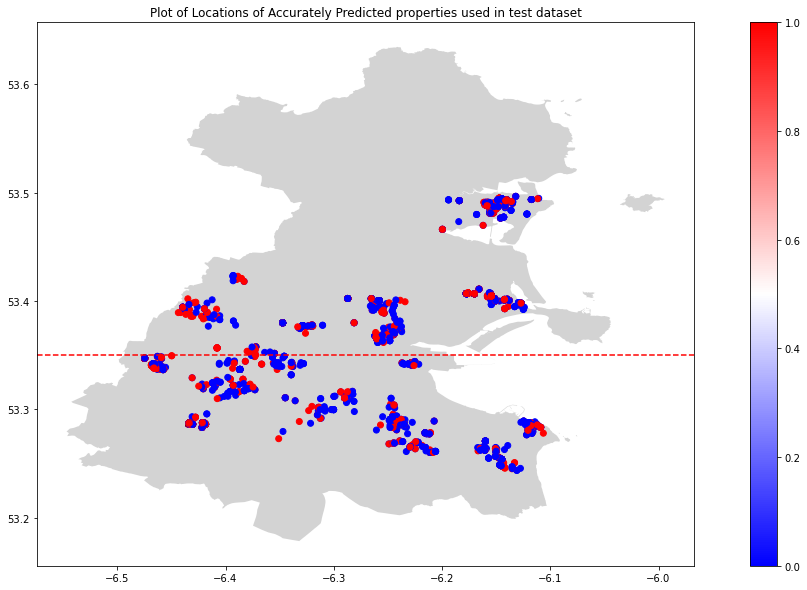

In [299]:
### RED = accurate , BLUE = Inaccurate
fig, ax = plt.subplots(figsize = (20, 10))
# O'Connell St. lat is 53.34975, and the longitude is -6.260113
dub1.plot(ax = ax, color = 'lightgrey')
ax.axhline(y = 53.34975, color = 'r', linestyle = '--')
plt.scatter(x = exp1['Longitude'], y = exp1['Latitude'], c = exp1['Accurate'], cmap = 'bwr')
plt.title('Plot of Locations of Accurately Predicted properties used in test dataset')
plt.colorbar()
plt.show()